# Lab Practice: Online Learning
**Interuniversity Master’s Degree in Artificial Intelligence**  
**Course:** Machine Learing II (MLII)  
**Academic Year:** 2025–2026  

---

## Group Members
- Cristian Marquina
- Francisco Vázquez
- Jose Carlos Bordón Maldonado
- Daniel González Filgueira
- Gian Paolo Belleddu

---

## Problem Description
The goal of this project is to predict the future price of a financial asset (specifically, the "High" price of the SPY ETF five days into the future). By forecasting these values, we aim to provide a tool that helps in anticipating market trends and making informed investment decisions.

Machine Learning Viewpoint:
* Problem Type: This is a regression problem, as the target variable ($Target\_High$) is a continuous numerical value representing a stock price.
* Imbalance: While not a classification problem (where class imbalance is typical), we must monitor for volatility spikes or extreme outliers in stock prices that could bias the model.
* Influence of Drift: Financial markets are highly dynamic. The dataset is likely influenced by concept drift due to changing economic cycles, interest rate updates, or geopolitical events.
* Evaluation Metrics: We use Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) to measure performance.
* Assumptions: We assume that historical patterns in price and volume contain predictive information and that the temporal order must be strictly preserved.

---

## Dataset Selection
The selected dataset contains historical stock prices for the SPY ETF.

* Suitability for Stream Learning: It contains a clear temporal component (daily records), which is essential for simulating a data stream.

* Origin: This is an external dataset (from Kaggle), providing a more realistic and complex scenario than built-in library datasets.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import tensorflow as tf

# Batch Libraries (Scikit-Learn)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Deep Learning Libraries (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Online Libraries (River)
from river import compose, tree, metrics, preprocessing, neighbors, linear_model, optim, ensemble, drift

# Utilities
from lab1_utils import *

# Configuration
DATA_DIR = 'data/'
IMG_DIR = 'images/'

# Seeds for reproducibility. River seeds are set in the model definitions (KNN and Linear Regression do not have a seed parameter)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Data loading and target preparation

In [3]:
# Load dataset
file_path = DATA_DIR + 'spy.us.txt'
df = pd.read_csv(file_path)

# Delete 'OpenInt' column (always 0 value)
if 'OpenInt' in df.columns:
    df = df.drop(columns=['OpenInt'])
    print("'OpenInt' column deleted successfully")

print(f"Initial number of rows: {len(df)}")

# Delete rows with missing values
df_cleaned = df.dropna()

print(f"Final columns: {df_cleaned.columns.tolist()}")
print(f"Final number of rows: {len(df_cleaned)}")

# Save cleaned dataset
df_cleaned.to_csv(DATA_DIR + 'spy_cleaned.csv', index=False)

'OpenInt' column deleted successfully
Initial number of rows: 3201
Final columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Final number of rows: 3201


In [4]:
# Load cleaned dataset
df = pd.read_csv(DATA_DIR + 'spy_cleaned.csv')

# Create the target: the 'High' 5 records ahead
# shift(-5) moves the values up by 5 positions.
# We are now predicting the value 5 days into the future to avoid naive correlation.
df['Target_High'] = df['High'].shift(-5)

# The last 5 rows do not have a "5th day future," so they become null (NaN)
df = df.dropna(subset=['Target_High'])

# Verify that Target_High is indeed the next day's High
print("\nFirst rows of the transformed dataset:")
df[['Date', 'High', 'Target_High']].head(21)


First rows of the transformed dataset:


,Date,High,Target_High
0,2005-02-25,106.00,107.01
1,2005-02-28,105.68,107.38
2,2005-03-01,105.87,107.15
3,2005-03-02,106.22,106.52
4,2005-03-03,106.20,105.85
5,2005-03-04,107.01,106.04
6,2005-03-07,107.38,105.56
7,2005-03-08,107.15,105.82
8,2005-03-09,106.52,104.44
9,2005-03-10,105.85,104.31


## Batch Learning

### Feature extraction and data splitting

In [5]:
# Data Splitting (Temporal Split - NO SHUFFLE): 70% training, 15% validation, and 15% test
n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

print(f"Total samples: {n}")

# Generate features and target for the entire dataset (train + val + test) to ensure we have the necessary history for feature generation
# This prevents the first 20 rows of the validation or test sets from becoming NaN due to insufficient historical data
X_full, y_full = get_batch_features_and_target(df)
print(f"Full shapes: X={X_full.shape}, y={y_full.shape}")

# Data splitting based on indices making sure that the cut respects the reduced dataframe after feature generation
X_train = X_full.loc[X_full.index < train_end]
y_train = y_full.loc[y_full.index < train_end]

X_val = X_full.loc[(X_full.index >= train_end) & (X_full.index < val_end)]
y_val = y_full.loc[(y_full.index >= train_end) & (y_full.index < val_end)]

X_test = X_full.loc[X_full.index >= val_end]
y_test = y_full.loc[y_full.index >= val_end]

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Val shapes: X={X_val.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Total samples: 3196
Full shapes: X=(3176, 8), y=(3176,)
Train shapes: X=(2217, 8), y=(2217,)
Val shapes: X=(479, 8), y=(479,)
Test shapes: X=(480, 8), y=(480,)


In [6]:
X_train.head()

,Close,Return,Mean_return_5,Mean_return_20,Volatility_20,Open_Close_Diff,Volume,Volume_dev
20,102.19,0.001372,-0.002071,-0.001712,0.005964,-0.10,53885043,-15613298.30
21,101.51,-0.006654,-0.002686,-0.001709,0.005962,-0.54,83849903,14143833.75
22,102.96,0.014284,0.002193,-0.001252,0.006766,1.11,72199510,1613835.85
23,102.77,-0.001845,0.001667,-0.001320,0.006765,-0.20,74669192,4036712.75
24,102.30,-0.004573,0.000517,-0.001568,0.006789,-1.04,111800673,39142501.25


In [7]:
y_train.head()

20    102.67
21    103.12
22    103.62
23    103.89
24    103.85
Name: Target_High, dtype: float64

In [8]:
# Scale the data (standarization) to avoid inestability
scaler = StandardScaler()
# Obtain mean and std from the training data only to prevent data leakage
scaler.fit(X_train)

# Transfrom all sets with the obtained parameters from training set
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Shapes after scaling:")
print(f"Train shapes: X={X_train_scaled.shape}, y={y_train.shape}")
print(f"Val shapes: X={X_val_scaled.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test_scaled.shape}, y={y_test.shape}")

Shapes after scaling:
Train shapes: X=(2217, 8), y=(2217,)
Val shapes: X=(479, 8), y=(479,)
Test shapes: X=(480, 8), y=(480,)


### Model 1: RandomForest

In [8]:

# to test param
param_grid = {
    'max_depth':        [5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features':     ['sqrt', 0.5, 1.0],
}

# PredefinedSplit ensures the validation fold is always the same predefined split,
# preventing GridSearchCV from randomly shuffling the data across folds.
# This is critical for time series data, where future data must never be used to train the model.
# -1 = training samples, 0 = validation samples
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
ps = PredefinedSplit(split_index)

X_trainval = np.concatenate([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

grid_search = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    param_grid,
    cv=ps,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search.fit(X_trainval, y_trainval)

print(f"Best param: {grid_search.best_params_}")
print(f"Best Val MAE:      {-grid_search.best_score_:.4f}")

Fitting 1 folds for each of 48 candidates, totalling 48 fits
Best param: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 5}
Best Val MAE:      19.4975


best one: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 5}

Plot saved as 'images/best_train_predictions_rf.png'


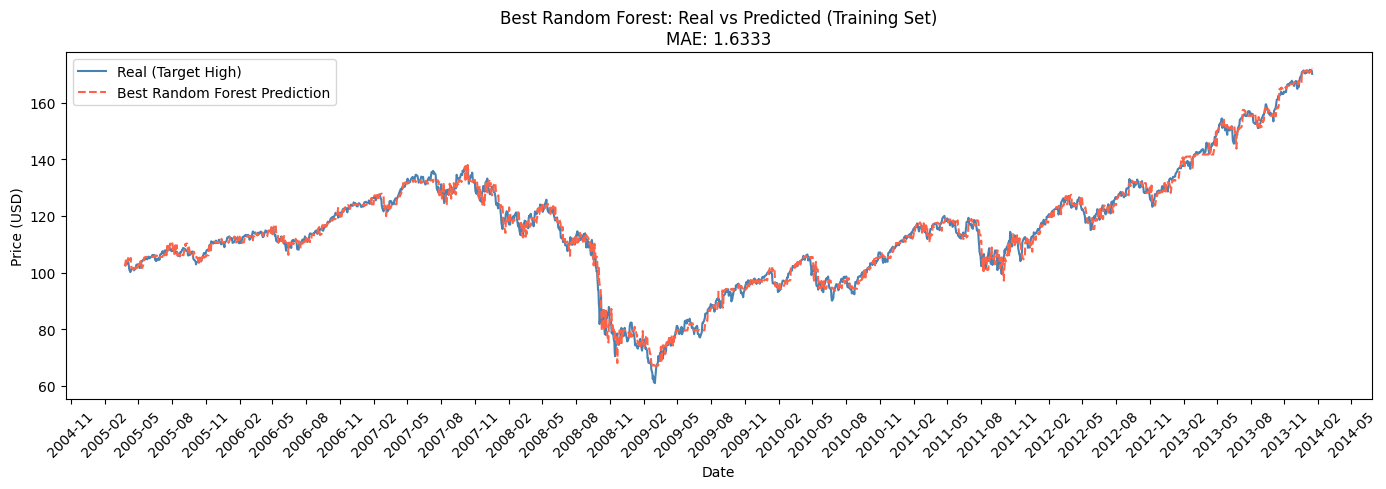

Plot saved as 'images/best_validation_predictions_rf.png'


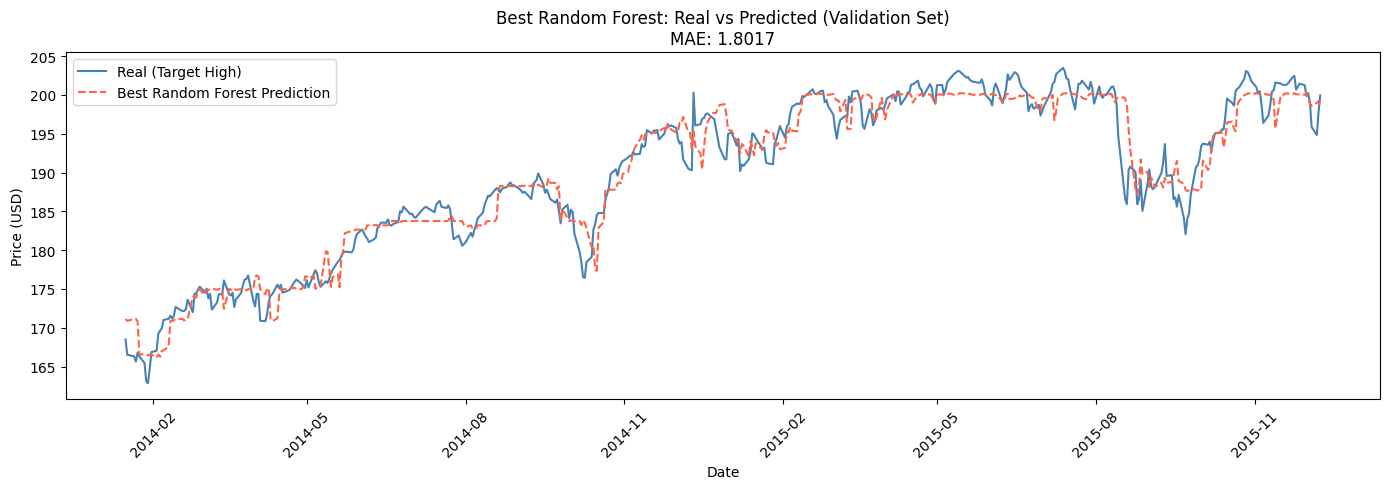

Plot saved as 'images/best_test_predictions_rf.png'


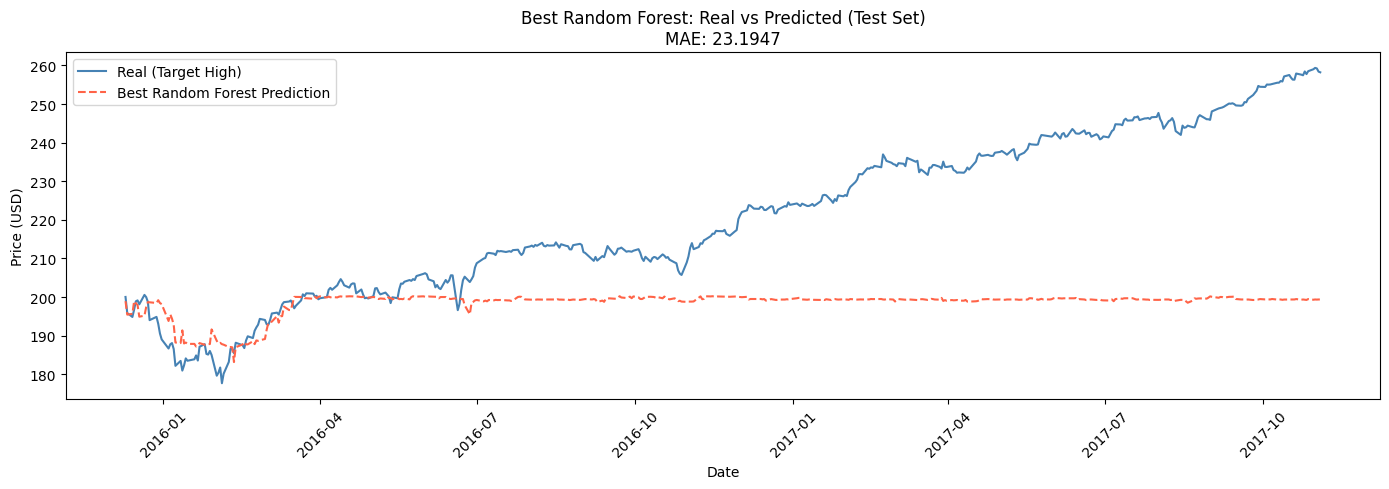

Best RF -> Train MAE: 1.6333
Best RF -> Val MAE:   1.8017
Best RF -> Test MAE:  23.1947


In [9]:
best_rf = grid_search.best_estimator_

print(f"best one: {grid_search.best_params_}\n")

mae_best_train = plot_predictions(best_rf, X_train_scaled, y_train, df, 'Training',   'Best Random Forest', filename=IMG_DIR + 'best_train_predictions_rf.png')
mae_best_val   = plot_predictions(best_rf, X_val_scaled,   y_val,   df, 'Validation', 'Best Random Forest', filename=IMG_DIR + 'best_validation_predictions_rf.png')
mae_best_test  = plot_predictions(best_rf, X_test_scaled,  y_test,  df, 'Test',       'Best Random Forest', filename=IMG_DIR + 'best_test_predictions_rf.png')

print(f"Best RF -> Train MAE: {mae_best_train:.4f}")
print(f"Best RF -> Val MAE:   {mae_best_val:.4f}")
print(f"Best RF -> Test MAE:  {mae_best_test:.4f}")

### Model 2: GradientBoosting

In [10]:
param_grid_gb = {
    'n_estimators':     [100, 200],
    'learning_rate':    [0.01, 0.05, 0.1],
    'max_depth':        [3, 5, 7],
    'min_samples_leaf': [1, 5, 10],
}

# PredefinedSplit ensures the validation fold is always the same predefined split,
# preventing GridSearchCV from randomly shuffling the data across folds.
# This is critical for time series data, where future data must never be used to train the model.
# -1 = training samples, 0 = validation samples
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
ps = PredefinedSplit(split_index)

X_trainval = np.concatenate([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

grid_search_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=ps,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search_gb.fit(X_trainval, y_trainval)

print(f"Best params: {grid_search_gb.best_params_}")
print(f"Best Val MAE: {-grid_search_gb.best_score_:.4f}")

Fitting 1 folds for each of 54 candidates, totalling 54 fits
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Best Val MAE: 19.2517


Plot saved as 'images/best_train_predictions_gb.png'


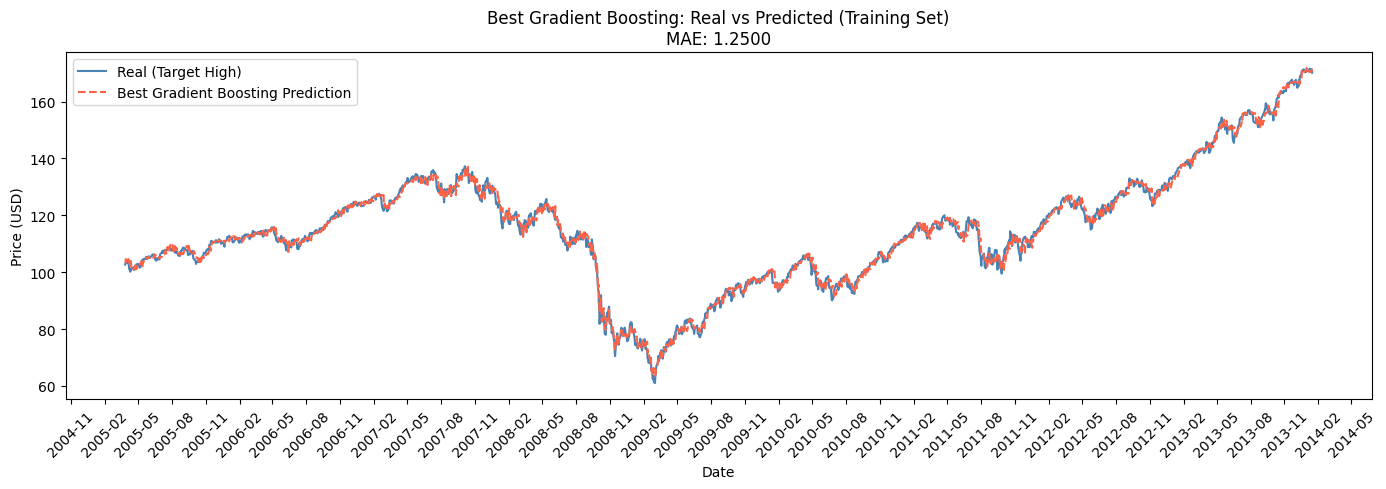

Plot saved as 'images/best_validation_predictions_gb.png'


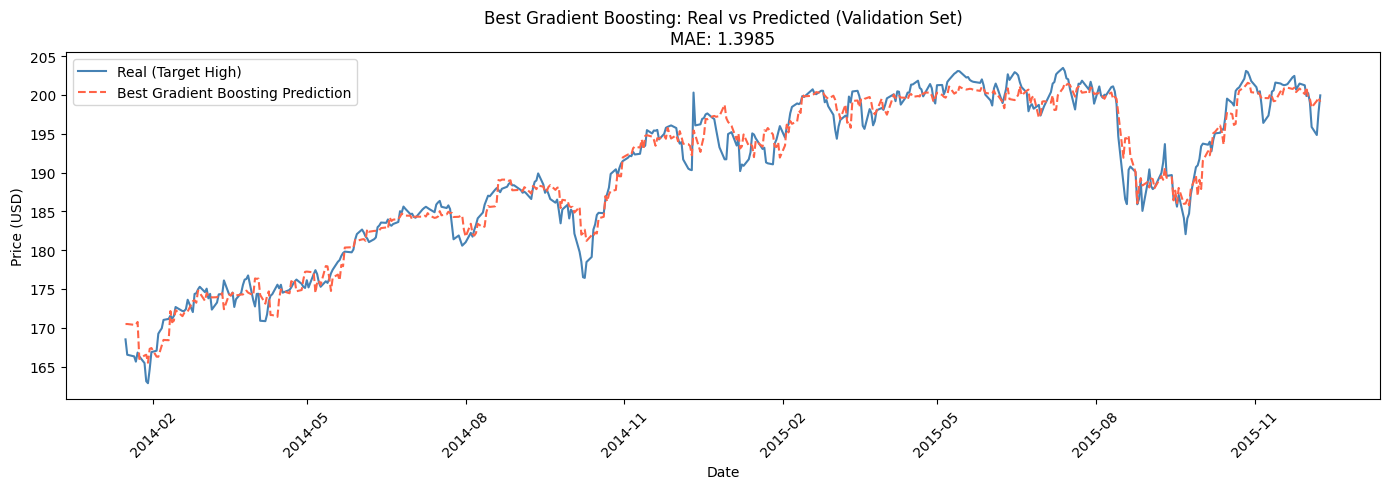

Plot saved as 'images/best_test_predictions_gb.png'


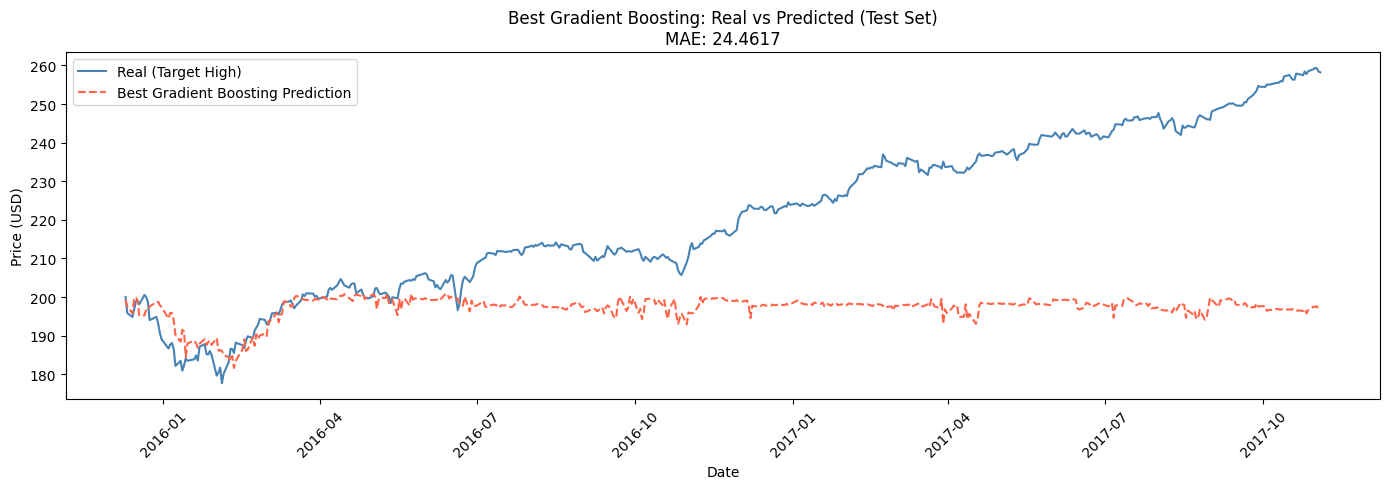

Best GBM -> Train MAE: 1.2500
Best GBM -> Val MAE:   1.3985
Best GBM -> Test MAE:  24.4617


In [11]:
best_gb = grid_search_gb.best_estimator_

mae_best_gb_train = plot_predictions(best_gb, X_train_scaled, y_train, df, 'Training',   'Best Gradient Boosting', filename=IMG_DIR + 'best_train_predictions_gb.png')
mae_best_gb_val   = plot_predictions(best_gb, X_val_scaled,   y_val,   df, 'Validation', 'Best Gradient Boosting', filename=IMG_DIR + 'best_validation_predictions_gb.png')
mae_best_gb_test  = plot_predictions(best_gb, X_test_scaled,  y_test,  df, 'Test',       'Best Gradient Boosting', filename=IMG_DIR + 'best_test_predictions_gb.png')

print(f"Best GBM -> Train MAE: {mae_best_gb_train:.4f}")
print(f"Best GBM -> Val MAE:   {mae_best_gb_val:.4f}")
print(f"Best GBM -> Test MAE:  {mae_best_gb_test:.4f}")

Bridge variables ready: X_tr=(2217, 8), X_vl=(479, 8), X_te=(480, 8)
Number of features: 8
MLP shapes: train=(2217, 8), val=(479, 8), test=(480, 8)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,897 (222.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 110.4546 - val_loss: 177.7934
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 68.9960 - val_loss: 49.5703
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.3474 - val_loss: 20.8664
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 18.3143 - val_loss: 15.9541
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.6598 - val_loss: 16.4653
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.5660 - val_loss: 13.7179
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.2418 - val_loss: 11.8794
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.3263 - val_loss: 14.1532
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.2106 - val_loss: 15.0793
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11.6997 - val_loss: 18.4444
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.9053 - val_loss: 14.0210
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━

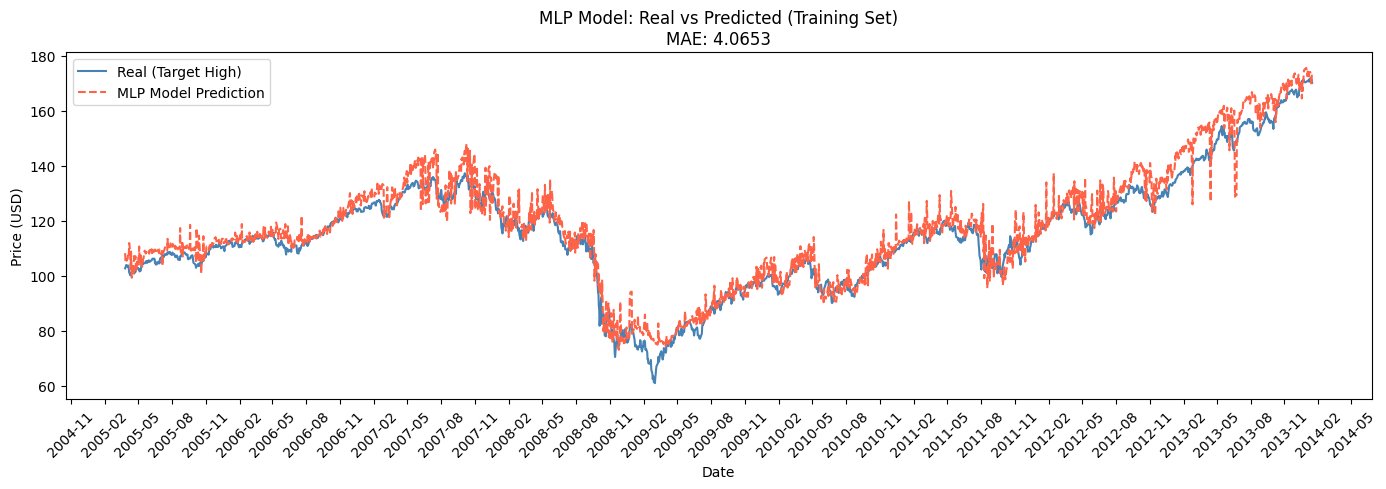

Plot saved as 'images/validation_predictions_mlp.png'


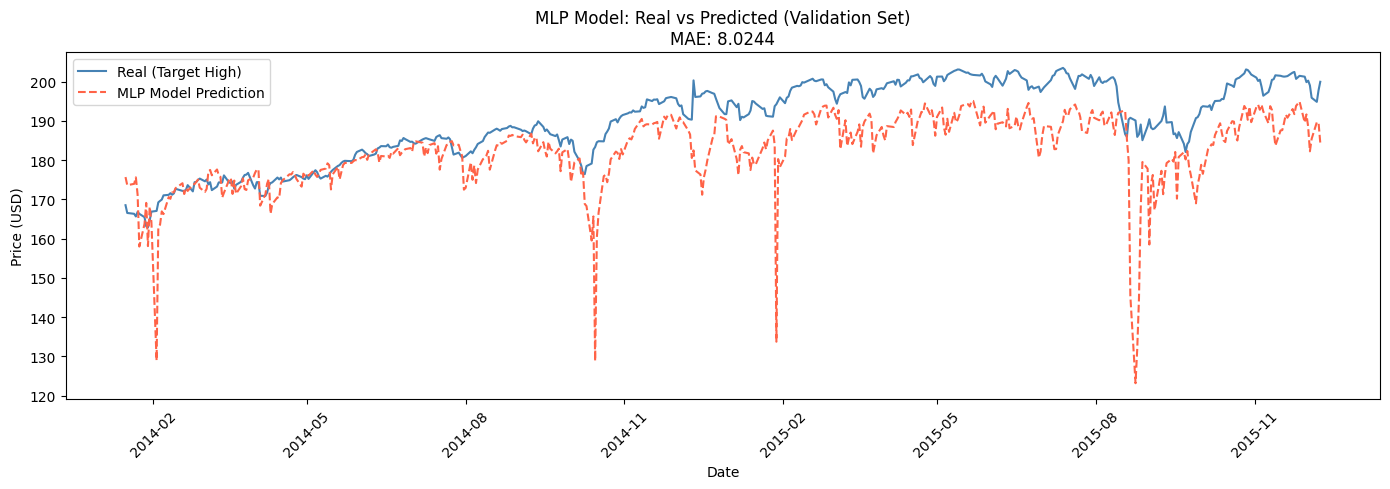

Plot saved as 'images/test_predictions_mlp.png'


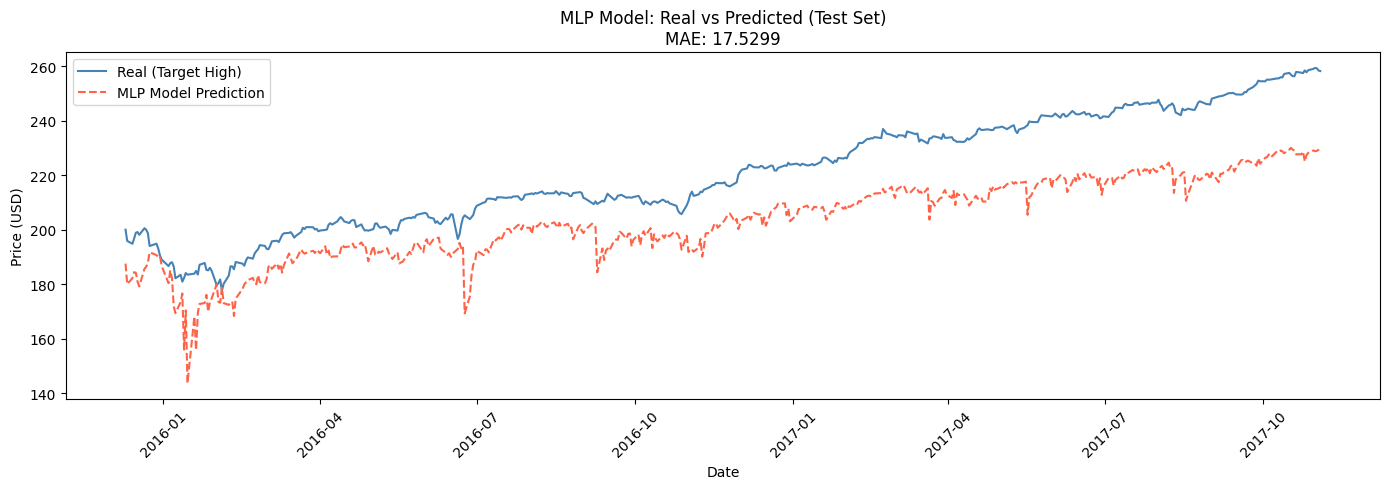

17.529894215647378

In [10]:
n_features = X_train_scaled.shape[1]
print(f"Bridge variables ready: X_tr={X_train_scaled.shape}, X_vl={X_val_scaled.shape}, X_te={X_test_scaled.shape}")
print(f"Number of features: {n_features}")
print(f"MLP shapes: train={X_train_scaled.shape}, val={X_val_scaled.shape}, test={X_test_scaled.shape}")

# MLP Architecture
model_mlp = Sequential([
    Input(shape=(n_features,)),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),

    Dense(1)
])

model_mlp.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mae'
)

model_mlp.summary()

# Train with EarlyStopping
history_mlp = model_mlp.fit(
    X_train_scaled, y_train.values,
    validation_data=(X_val_scaled, y_val.values),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )],
    verbose=1
)

# Evaluate
y_pred_train_mlp = model_mlp.predict(X_train_scaled, verbose=0).flatten()
y_pred_val_mlp   = model_mlp.predict(X_val_scaled, verbose=0).flatten()
y_pred_test_mlp  = model_mlp.predict(X_test_scaled, verbose=0).flatten()

mae_train_mlp = mean_absolute_error(y_train.values, y_pred_train_mlp)
mae_val_mlp   = mean_absolute_error(y_val.values, y_pred_val_mlp)
mae_test_mlp  = mean_absolute_error(y_test.values, y_pred_test_mlp)

print(f"\n--- MLP Model ---")
print(f"Train MAE: {mae_train_mlp:.4f}")
print(f"Val   MAE: {mae_val_mlp:.4f}")
print(f"Test  MAE: {mae_test_mlp:.4f}")

# Plots
plot_predictions_LPM(y_train.values, y_pred_train_mlp, X_train.index, df, 'Training', 'MLP Model', filename=IMG_DIR + 'train_predictions_mlp.png')
plot_predictions_LPM(y_val.values, y_pred_val_mlp,   X_val.index,   df, 'Validation', 'MLP Model', filename=IMG_DIR + 'validation_predictions_mlp.png')
plot_predictions_LPM(y_test.values, y_pred_test_mlp,  X_test.index,  df, 'Test', 'MLP Model', filename=IMG_DIR + 'test_predictions_mlp.png')

Starting GridSearch for MLP...

--- Run 1/12 | layers=(64, 32), dropout=0.2, lr=0.001 ---
  Val MAE: 2.9329
--- Run 2/12 | layers=(64, 32), dropout=0.3, lr=0.0005 ---
  Val MAE: 4.4487
--- Run 3/12 | layers=(128, 64), dropout=0.2, lr=0.001 ---
  Val MAE: 3.1919
--- Run 4/12 | layers=(128, 64), dropout=0.3, lr=0.0005 ---
  Val MAE: 3.0971
--- Run 5/12 | layers=(128, 64), dropout=0.2, lr=0.0001 ---
  Val MAE: 120.4340
--- Run 6/12 | layers=(128, 64), dropout=0.3, lr=0.0001 ---
  Val MAE: 131.1845
--- Run 7/12 | layers=(128, 128, 64), dropout=0.2, lr=0.001 ---
  Val MAE: 2.6780
--- Run 8/12 | layers=(128, 128, 64), dropout=0.3, lr=0.0005 ---
  Val MAE: 3.0302
--- Run 9/12 | layers=(128, 128, 64), dropout=0.2, lr=0.0001 ---
  Val MAE: 138.9577
--- Run 10/12 | layers=(128, 128, 128, 128, 32), dropout=0.2, lr=0.001 ---
  Val MAE: 2.5897
--- Run 11/12 | layers=(128, 128, 128, 128, 32), dropout=0.3, lr=0.0005 ---
  Val MAE: 3.8405
--- Run 12/12 | layers=(128, 128, 128, 128, 32), dropout=0.3, l

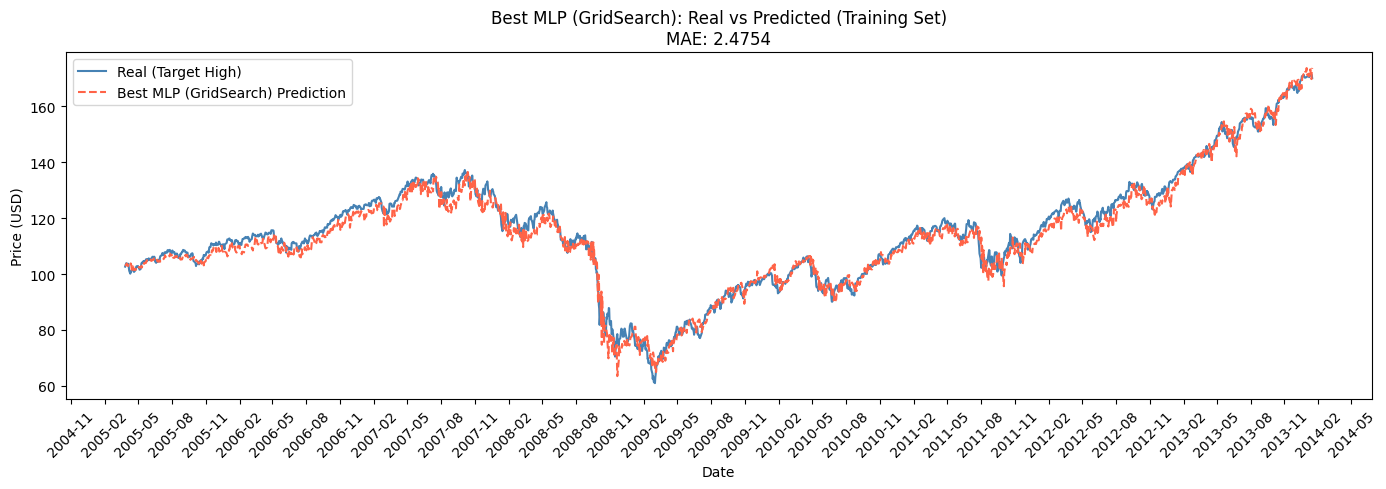

Plot saved as 'images/best_validation_predictions_mlp.png'


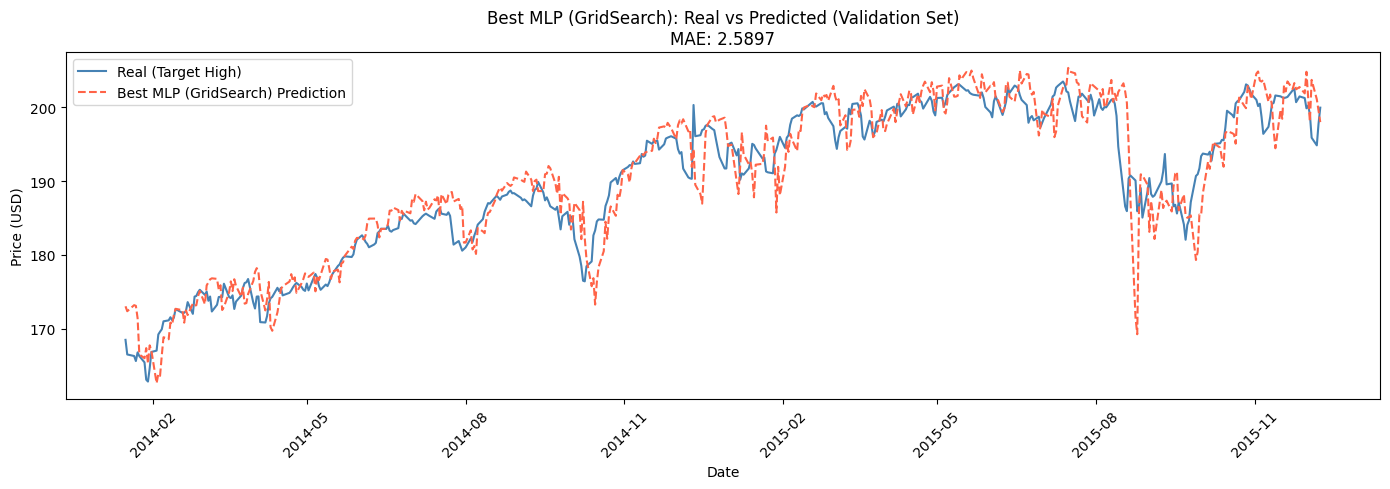

Plot saved as 'images/best_test_predictions_mlp.png'


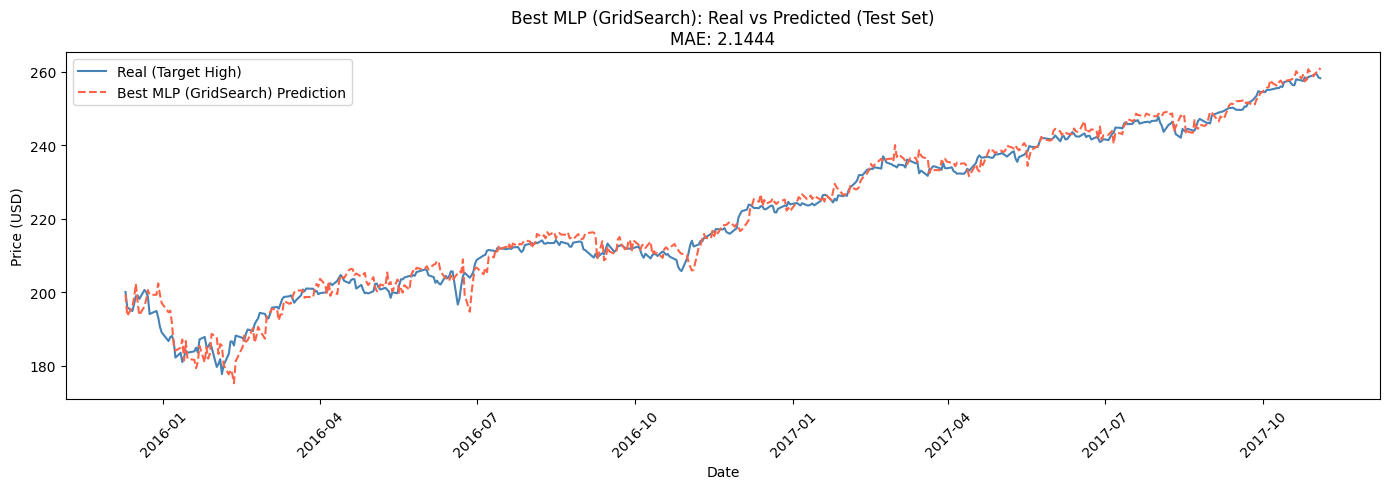

2.14442585144043

In [11]:
# GridSearch for MLP

def build_mlp(n_features, hidden_layers, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae')
    return model

# 12 configurations
configurations_mlp = [
    {'hidden_layers': (64, 32),                'dropout_rate': 0.2, 'learning_rate': 1e-3},
    {'hidden_layers': (64, 32),                'dropout_rate': 0.3, 'learning_rate': 5e-4},
    {'hidden_layers': (128, 64),               'dropout_rate': 0.2, 'learning_rate': 1e-3},
    {'hidden_layers': (128, 64),               'dropout_rate': 0.3, 'learning_rate': 5e-4},
    {'hidden_layers': (128, 64),               'dropout_rate': 0.2, 'learning_rate': 1e-4},
    {'hidden_layers': (128, 64),               'dropout_rate': 0.3, 'learning_rate': 1e-4},
    {'hidden_layers': (128, 128, 64),          'dropout_rate': 0.2, 'learning_rate': 1e-3},
    {'hidden_layers': (128, 128, 64),          'dropout_rate': 0.3, 'learning_rate': 5e-4},
    {'hidden_layers': (128, 128, 64),          'dropout_rate': 0.2, 'learning_rate': 1e-4},
    {'hidden_layers': (128, 128, 128, 128, 32),'dropout_rate': 0.2, 'learning_rate': 1e-3},
    {'hidden_layers': (128, 128, 128, 128, 32),'dropout_rate': 0.3, 'learning_rate': 5e-4},
    {'hidden_layers': (128, 128, 128, 128, 32),'dropout_rate': 0.3, 'learning_rate': 1e-4},
]

best_val_mae_mlp = float('inf')
best_config_mlp = None
best_mlp = None

print("Starting GridSearch for MLP...\n")

for run, config in enumerate(configurations_mlp, 1):
    print(f"--- Run {run}/{len(configurations_mlp)} | layers={config['hidden_layers']}, "
          f"dropout={config['dropout_rate']}, lr={config['learning_rate']} ---")

    tf.random.set_seed(SEED)
    np.random.seed(SEED)

    model = build_mlp(n_features, config['hidden_layers'], config['dropout_rate'], config['learning_rate'])

    model.fit(
        X_train_scaled, y_train.values,
        validation_data=(X_val_scaled, y_val.values),
        epochs=100,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)],
        verbose=0
    )

    y_pred_val = model.predict(X_val_scaled, verbose=0).flatten()
    current_val_mae = mean_absolute_error(y_val.values, y_pred_val)
    print(f"  Val MAE: {current_val_mae:.4f}")

    if current_val_mae < best_val_mae_mlp:
        best_val_mae_mlp = current_val_mae
        best_config_mlp = config
        best_mlp = model

# Best model results
print("\n" + "=" * 50)
print("BEST MLP MODEL FOUND")
print(f"Config: layers={best_config_mlp['hidden_layers']}, "
      f"dropout={best_config_mlp['dropout_rate']}, lr={best_config_mlp['learning_rate']}")
print("=" * 50)

y_pred_train_best = best_mlp.predict(X_train_scaled, verbose=0).flatten()
y_pred_val_best   = best_mlp.predict(X_val_scaled,   verbose=0).flatten()
y_pred_test_best  = best_mlp.predict(X_test_scaled,  verbose=0).flatten()

mae_best_mlp_train = mean_absolute_error(y_train.values, y_pred_train_best)
mae_best_mlp_val   = mean_absolute_error(y_val.values,   y_pred_val_best)
mae_best_mlp_test  = mean_absolute_error(y_test.values,  y_pred_test_best)

print(f"Best MLP -> Train MAE: {mae_best_mlp_train:.4f}")
print(f"Best MLP -> Val   MAE: {mae_best_mlp_val:.4f}")
print(f"Best MLP -> Test  MAE: {mae_best_mlp_test:.4f}")

plot_predictions_LPM(y_train.values, y_pred_train_best, X_train.index, df, 'Training',   'Best MLP (GridSearch)', filename=IMG_DIR + 'best_train_predictions_mlp.png')
plot_predictions_LPM(y_val.values,   y_pred_val_best,   X_val.index,   df, 'Validation', 'Best MLP (GridSearch)', filename=IMG_DIR + 'best_validation_predictions_mlp.png')
plot_predictions_LPM(y_test.values,  y_pred_test_best,  X_test.index,  df, 'Test',       'Best MLP (GridSearch)', filename=IMG_DIR + 'best_test_predictions_mlp.png')

### Concept Drift Detection (batch models)

In this section, we will analyze the presence of concept drift in our trained batch models across both the validation and test sets. 

Because batch models are trained on a fixed historical dataset, their predictive power naturally degrades over time as market dynamics change. To monitor this, we implemented the `analyze_and_plot_drift_batch` function. This function sequentially compares the model's predictions against the actual target values to compute a chronological stream of absolute errors. 

We then apply two classic concept drift detection algorithms—**ADWIN** and **Page-Hinkley**—directly to this error stream to identify the exact moments when the model's performance significantly deteriorates. Finally, the function visualizes the error trend alongside the detected drift points.

We selected these specific detectors because they perfectly complement each other when analyzing noisy financial time series:

* **ADWIN (ADaptive WINdowing):** This algorithm dynamically adjusts a sliding window of recent errors. If the average error in a newer sub-window becomes significantly different from an older sub-window, it flags a drift. We chose ADWIN because it is highly robust and mathematically guaranteed to detect both **gradual degradation** in model performance and sudden shifts, all without requiring us to guess or hardcode a specific window size.
* **Page-Hinkley (PH):** This is a sequential analysis technique designed to detect sudden changes in the mean of a signal. By calculating the cumulative sum of the observed errors, PH is extremely sensitive to **sudden, sharp market shocks** (like unexpected macroeconomic news or crashes). We chose it because it flags the exact moment a model's error spikes abruptly, indicating an immediate need for retraining.

By tracking these drift points, we can understand precisely when our static batch models become obsolete and require retraining with fresh data.


--- Analyzing Concept Drift for Random Forest (Validation Set) ---
ADWIN detected 1 drift points.
Page-Hinkley detected 3 drift points.
Plot saved as 'images/validation_drift_rf.png'


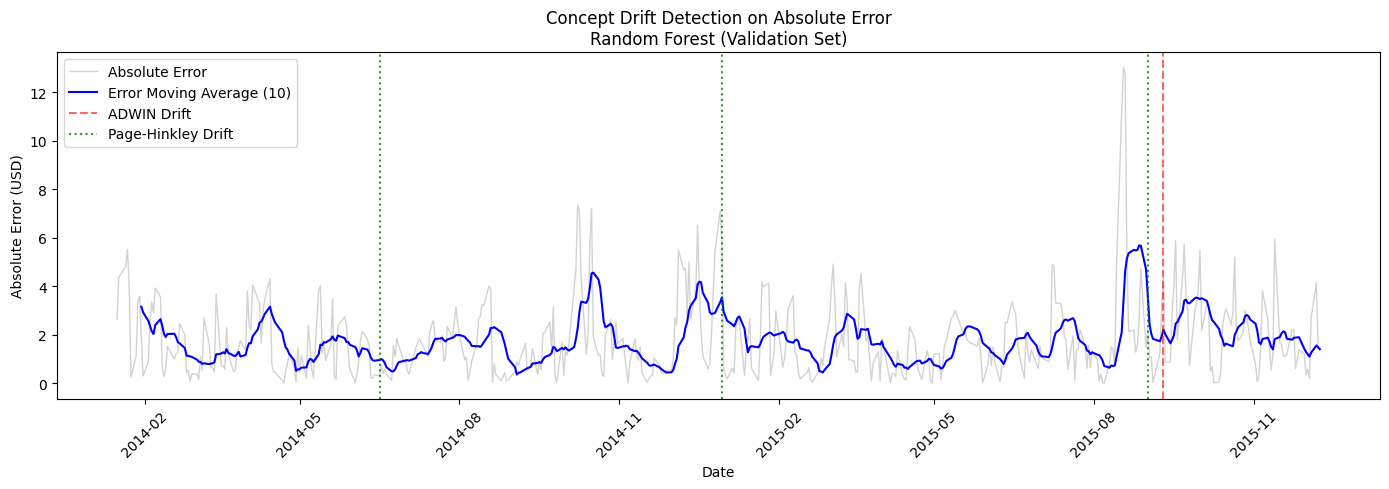


--- Analyzing Concept Drift for Random Forest (Test Set) ---
ADWIN detected 6 drift points.
Page-Hinkley detected 10 drift points.
Plot saved as 'images/test_drift_rf.png'


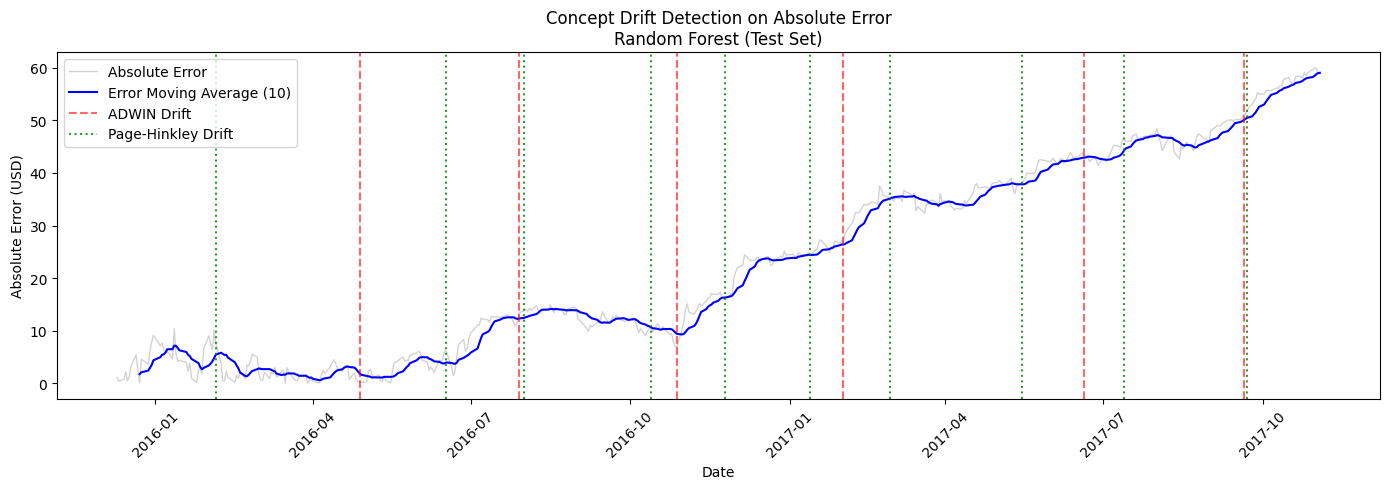

In [13]:
adwin_val_rf, ph_val_rf = analyze_and_plot_drift_batch(best_rf, X_val_scaled, y_val, df, 'Validation', 'Random Forest', filename=IMG_DIR + 'validation_drift_rf.png')
adwin_test_rf, ph_test_rf = analyze_and_plot_drift_batch(best_rf, X_test_scaled, y_test, df, 'Test', 'Random Forest', filename=IMG_DIR + 'test_drift_rf.png')


--- Analyzing Concept Drift for Gradient Boosting (Validation Set) ---
ADWIN detected 0 drift points.
Page-Hinkley detected 1 drift points.
Plot saved as 'images/validation_drift_gb.png'


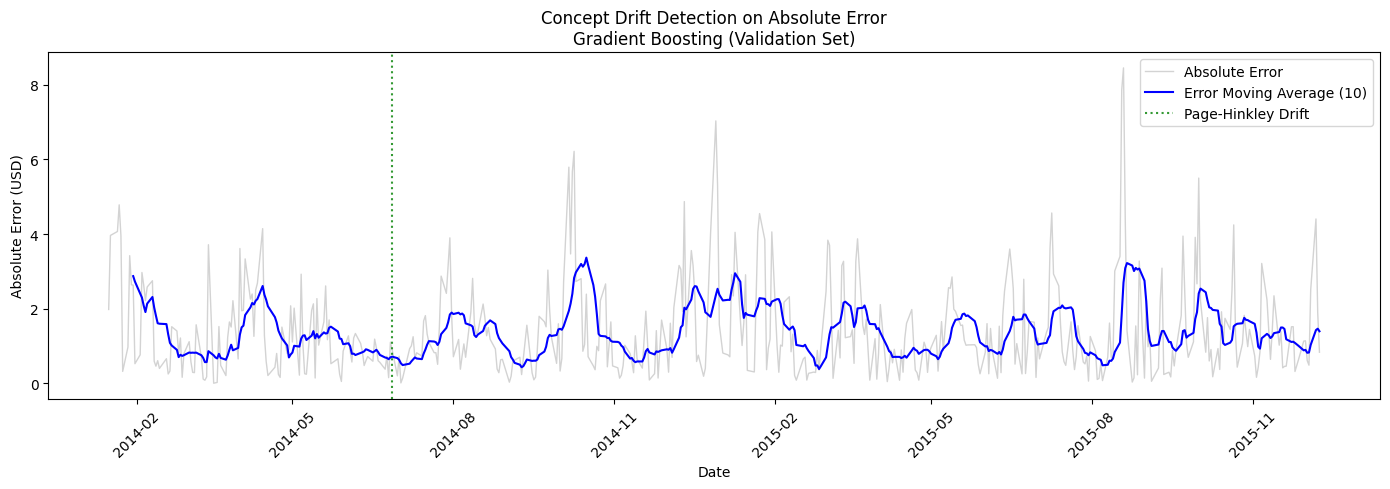


--- Analyzing Concept Drift for Gradient Boosting (Test Set) ---
ADWIN detected 5 drift points.
Page-Hinkley detected 10 drift points.
Plot saved as 'images/test_drift_gb.png'


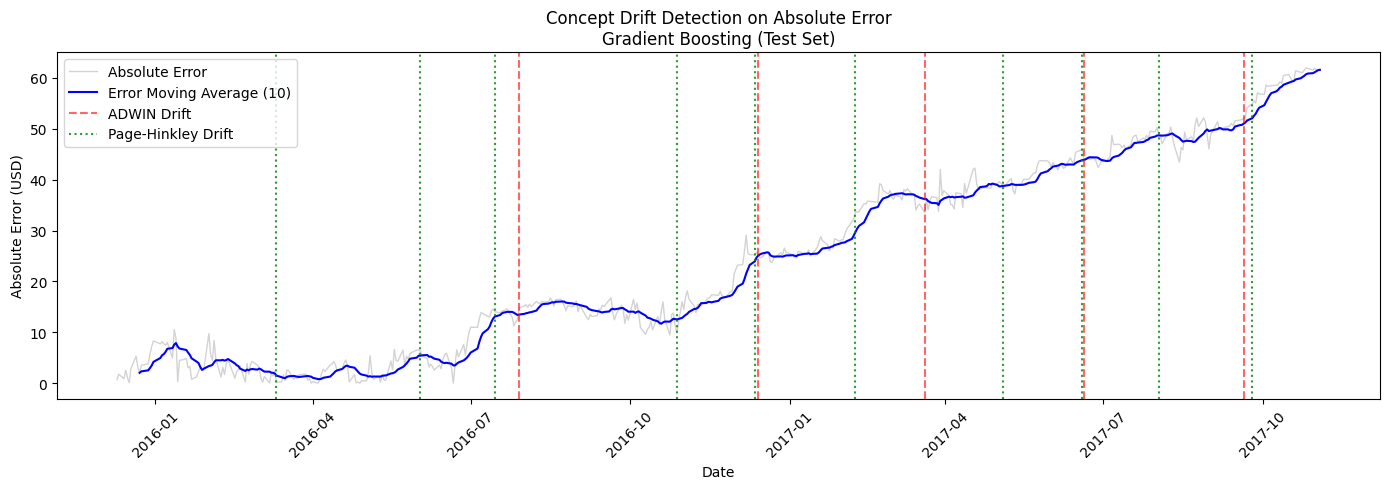

In [14]:
adwin_val_gb, ph_val_gb = analyze_and_plot_drift_batch(best_gb, X_val_scaled, y_val, df, 'Validation', 'Gradient Boosting', filename=IMG_DIR + 'validation_drift_gb.png')
adwin_test_gb, ph_test_gb = analyze_and_plot_drift_batch(best_gb, X_test_scaled, y_test, df, 'Test', 'Gradient Boosting', filename=IMG_DIR + 'test_drift_gb.png')

In [ ]:
adwin_val_mlp, ph_val_mlp = analyze_and_plot_drift_batch(best_mlp, X_val_scaled, y_val, df, 'Validation', 'MLP', filename=IMG_DIR + 'validation_drift_mlp.png')
adwin_test_mlp, ph_test_mlp = analyze_and_plot_drift_batch(best_mlp, X_test_scaled, y_test, df, 'Test', 'MLP', filename=IMG_DIR + 'test_drift_mlp.png')

## Online Learning

### Hoeffding Adaptive Tree Regressor

Starting Hyperparameter Tuning for Online Hoeffding Adaptive Tree...

--- Run 1/5 | Config: {'grace_period': 50, 'model_selector_decay': 0.9} ---
Result -> Val MAE: 3.5810 | Test MAE: 2.8285

--- Run 2/5 | Config: {'grace_period': 50, 'model_selector_decay': 0.95} ---
Result -> Val MAE: 3.4662 | Test MAE: 4.4865

--- Run 3/5 | Config: {'grace_period': 100, 'model_selector_decay': 0.9} ---
Result -> Val MAE: 4.4113 | Test MAE: 2.8554

--- Run 4/5 | Config: {'grace_period': 100, 'model_selector_decay': 0.99} ---
Result -> Val MAE: 6.1728 | Test MAE: 7.0071

--- Run 5/5 | Config: {'grace_period': 200, 'model_selector_decay': 0.95} ---
Result -> Val MAE: 3.0484 | Test MAE: 2.3695

BEST MODEL FOUND
Configuration : {'grace_period': 200, 'model_selector_decay': 0.95}
Validation MAE: 3.0484
Test MAE      : 2.3695
Plot saved as 'images/best_validation_predictions_hoef.png'


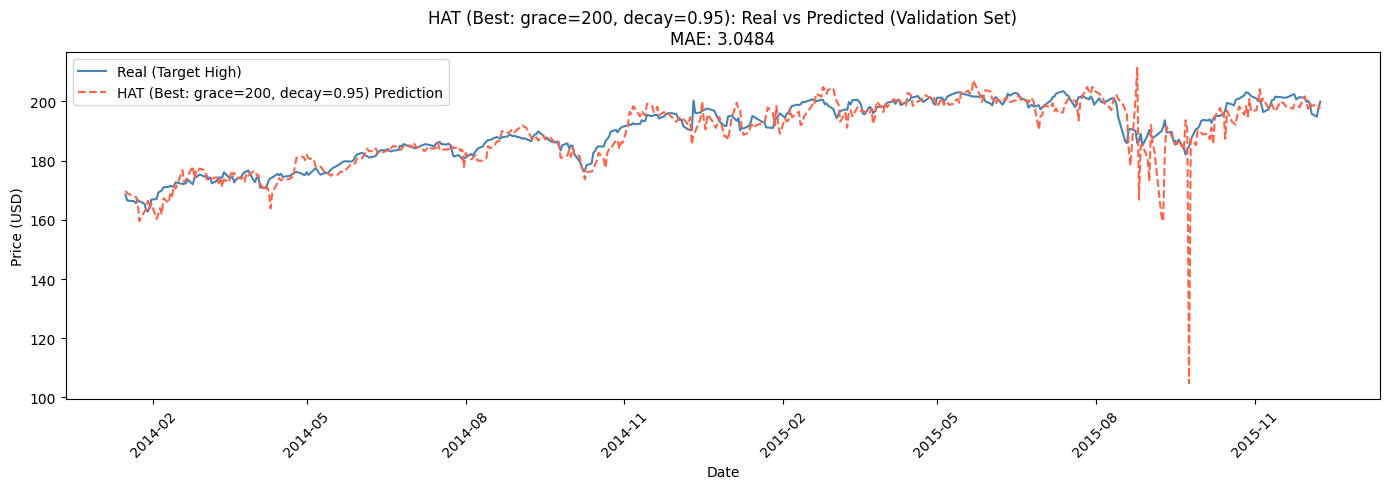

Plot saved as 'images/best_test_predictions_hoef.png'


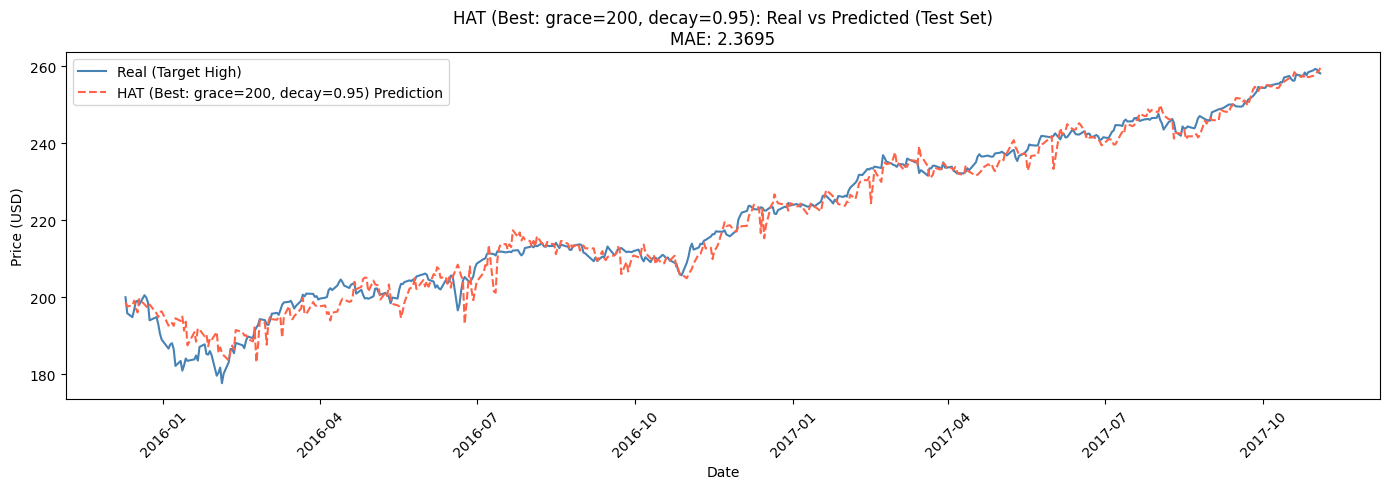

In [16]:
# 1. Define 5 hyperparameter configurations to test for Hoeffding Adaptive Tree
# grace_period: Number of instances a leaf must observe before attempting a split
# model_selector_decay: Decay factor for evaluating if an alternative branch is better than the current one
configurations_hoef = [
    {'grace_period': 50,  'model_selector_decay': 0.9},   # Fast growth, quick adaptation
    {'grace_period': 50,  'model_selector_decay': 0.95},  # Fast growth, slightly slower adaptation
    {'grace_period': 100, 'model_selector_decay': 0.9},   # Medium growth, quick adaptation
    {'grace_period': 100, 'model_selector_decay': 0.99},  # Medium growth, very stable adaptation
    {'grace_period': 200, 'model_selector_decay': 0.95}   # Slow/Stable growth, moderate adaptation
]

# Variables to keep track of the best model
best_val_mae_hoef = float('inf')
best_config_hoef = None
best_test_mae_hoef = None
best_records_val_hoef = []
best_records_test_hoef = []

print("Starting Hyperparameter Tuning for Online Hoeffding Adaptive Tree...\n")

# 2. Loop through each configuration
for run, config in enumerate(configurations_hoef, 1):
    print(f"--- Run {run}/5 | Config: {config} ---")
    
    # We MUST recreate the pipeline from scratch for each run 
    # to prevent the tree from carrying over memory/growth from the previous run.
    river_model_hoef = compose.Pipeline(
        OnlineSPYFeatures(),
        preprocessing.StandardScaler(),  # Scales the data (standarization) to avoid inestability
        tree.HoeffdingAdaptiveTreeRegressor(
            grace_period=config['grace_period'],
            model_selector_decay=config['model_selector_decay'],
            seed=SEED
        )
    )

    # Initialize fresh metrics and lists for this run
    metric_val_hoef  = metrics.MAE()
    metric_test_hoef = metrics.MAE()
    records_val_hoef  = []
    records_test_hoef = []

    # 3. Training Loop (Test-then-Train)
    for index, row in df.iterrows():
        x = row[['Open', 'High', 'Low', 'Close', 'Volume']].to_dict()
        y = row['Target_High']
        
        # PREDICTION
        y_pred = river_model_hoef.predict_one(x)
        
        # UPDATE METRICS
        if index in X_val.index:
            metric_val_hoef.update(y, y_pred)
            records_val_hoef.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        elif index in X_test.index:
            metric_test_hoef.update(y, y_pred)
            records_test_hoef.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        # LEARNING
        river_model_hoef.learn_one(x, y)

    # Current run results
    current_val_mae = metric_val_hoef.get()
    current_test_mae = metric_test_hoef.get()
    print(f"Result -> Val MAE: {current_val_mae:.4f} | Test MAE: {current_test_mae:.4f}\n")

    # 4. Check if this is the best model so far (based on Validation MAE)
    if current_val_mae < best_val_mae_hoef:
        best_val_mae_hoef = current_val_mae
        best_config_hoef = config
        best_test_mae_hoef = current_test_mae
        
        # Save the records of the best execution for later plotting
        best_records_val_hoef = records_val_hoef
        best_records_test_hoef = records_test_hoef

# 5. Final Results & Plotting
print("="*50)
print("BEST MODEL FOUND")
print(f"Configuration : {best_config_hoef}")
print(f"Validation MAE: {best_val_mae_hoef:.4f}")
print(f"Test MAE      : {best_test_mae_hoef:.4f}")
print("="*50)

# Plot using the records from the best configuration
plot_title = f"HAT (Best: grace={best_config_hoef['grace_period']}, decay={best_config_hoef['model_selector_decay']})"
mae_hat_val = plot_predictions_online(best_records_val_hoef, 'Validation', plot_title, filename=IMG_DIR + 'best_validation_predictions_hoef.png')
mae_hat_test = plot_predictions_online(best_records_test_hoef, 'Test', plot_title, filename=IMG_DIR + 'best_test_predictions_hoef.png')

### KNN regressor

K-Nearest Neighbors (KNN) is a promising model for time series forecasting because it identifies historical patterns that closely resemble current conditions. In this approach, we configure the model to find the 5 closest historical days (neighbors) to inform its current prediction.

To optimize performance and relevance, we restricted the search engine's memory to retain only the last 30 observed instances (approximately one trading month). This not only makes the model computationally more efficient by reducing the memory footprint, but it also prevents the algorithm from conflating current market behaviors with similar but contextually outdated situations from distant time periods.

Furthermore, we aggregate the targets of these 5 neighbors using the median rather than the mean. This ensures our predictions remain robust and are not disproportionately skewed by outliers or extreme, anomalous market fluctuations.

Starting Hyperparameter Tuning for Online KNN Regressor...

--- Run 1/5 | Config: {'n_neighbors': 3, 'window_size': 30, 'aggregation_method': 'median'} ---
Result -> Val MAE: 2.4790 | Test MAE: 2.8246

--- Run 2/5 | Config: {'n_neighbors': 5, 'window_size': 30, 'aggregation_method': 'median'} ---
Result -> Val MAE: 2.4241 | Test MAE: 2.9291

--- Run 3/5 | Config: {'n_neighbors': 5, 'window_size': 60, 'aggregation_method': 'median'} ---
Result -> Val MAE: 3.4458 | Test MAE: 4.3649

--- Run 4/5 | Config: {'n_neighbors': 7, 'window_size': 90, 'aggregation_method': 'mean'} ---
Result -> Val MAE: 4.1810 | Test MAE: 5.5038

--- Run 5/5 | Config: {'n_neighbors': 10, 'window_size': 30, 'aggregation_method': 'mean'} ---
Result -> Val MAE: 2.5643 | Test MAE: 3.1711

BEST MODEL FOUND
Configuration : {'n_neighbors': 5, 'window_size': 30, 'aggregation_method': 'median'}
Validation MAE: 2.4241
Test MAE      : 2.9291
Plot saved as 'images/best_validation_predictions_knn.png'


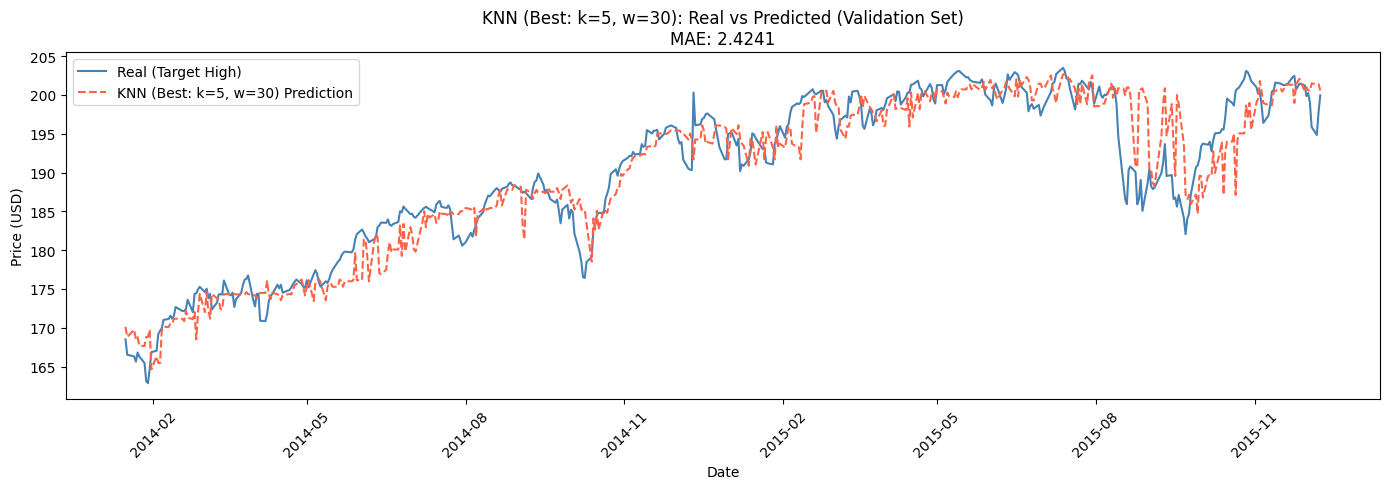

Plot saved as 'images/best_test_predictions_knn.png'


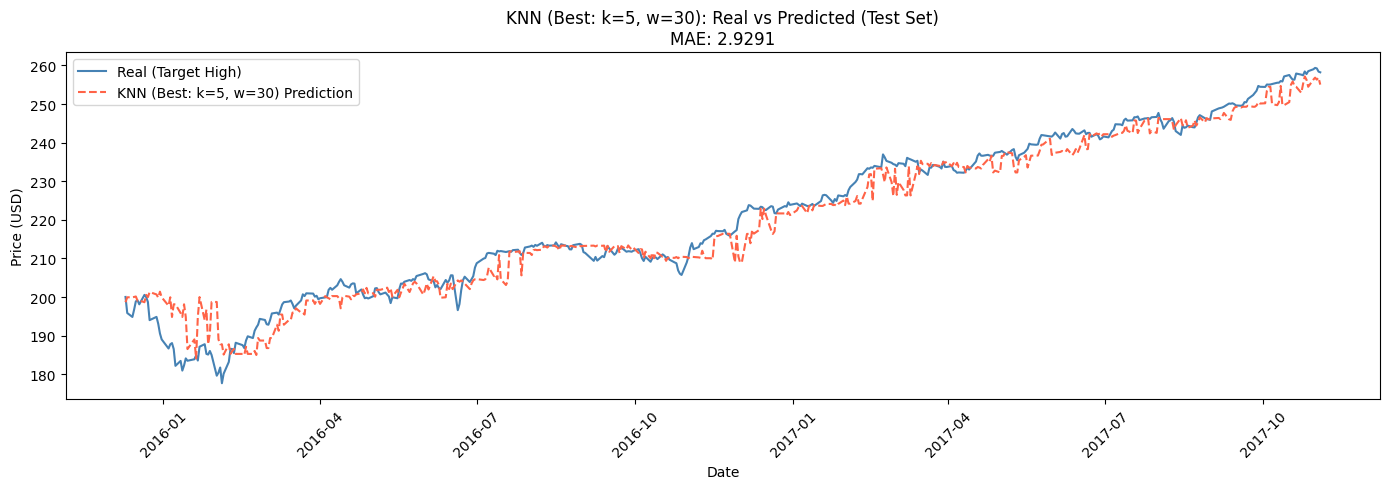

In [17]:
# 1. Define 5 hyperparameter configurations to test
configurations_knn = [
    {'n_neighbors': 3, 'window_size': 30, 'aggregation_method': 'median'},
    {'n_neighbors': 5, 'window_size': 30, 'aggregation_method': 'median'},
    {'n_neighbors': 5, 'window_size': 60, 'aggregation_method': 'median'}, # 2 months memory
    {'n_neighbors': 7, 'window_size': 90, 'aggregation_method': 'mean'},   # 3 months memory
    {'n_neighbors': 10, 'window_size': 30, 'aggregation_method': 'mean'}
]

# Variables to keep track of the best model
best_val_mae_knn = float('inf')
best_config_knn = None
best_test_mae_knn = None
best_records_val_knn = []
best_records_test_knn = []

print("Starting Hyperparameter Tuning for Online KNN Regressor...\n")

# 2. Loop through each configuration
for run, config in enumerate(configurations_knn, 1):
    print(f"--- Run {run}/5 | Config: {config} ---")
    
    # We MUST recreate the pipeline from scratch for each run 
    # to avoid mixing memory between different executions.
    river_model_knn = compose.Pipeline(
        OnlineSPYFeatures(),
        preprocessing.StandardScaler(), 
        neighbors.KNNRegressor(
            n_neighbors=config['n_neighbors'],
            engine=neighbors.LazySearch(window_size=config['window_size']),
            aggregation_method=config['aggregation_method']
        )
    )

    # Initialize fresh metrics and lists for this run
    metric_val_knn  = metrics.MAE()
    metric_test_knn = metrics.MAE()
    records_val_knn  = []
    records_test_knn = []

    # 3. Training Loop (Test-then-Train)
    for index, row in df.iterrows():
        x = row[['Open', 'High', 'Low', 'Close', 'Volume']].to_dict()
        y = row['Target_High']
        
        # PREDICTION
        y_pred = river_model_knn.predict_one(x)
        
        # UPDATE METRICS
        if index in X_val.index:
            metric_val_knn.update(y, y_pred)
            records_val_knn.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        elif index in X_test.index:
            metric_test_knn.update(y, y_pred)
            records_test_knn.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        # LEARNING
        river_model_knn.learn_one(x, y)

    # Current run results
    current_val_mae = metric_val_knn.get()
    current_test_mae = metric_test_knn.get()
    print(f"Result -> Val MAE: {current_val_mae:.4f} | Test MAE: {current_test_mae:.4f}\n")

    # 4. Check if this is the best model so far (based on Validation MAE)
    if current_val_mae < best_val_mae_knn:
        best_val_mae_knn = current_val_mae
        best_config_knn = config
        best_test_mae_knn = current_test_mae
        
        # Save the records of the best execution for later plotting
        best_records_val_knn = records_val_knn
        best_records_test_knn = records_test_knn

# 5. Final Results & Plotting
print("="*50)
print("BEST MODEL FOUND")
print(f"Configuration : {best_config_knn}")
print(f"Validation MAE: {best_val_mae_knn:.4f}")
print(f"Test MAE      : {best_test_mae_knn:.4f}")
print("="*50)

# Plot using the records from the best configuration
mae_knn_val = plot_predictions_online(best_records_val_knn, 'Validation', f"KNN (Best: k={best_config_knn['n_neighbors']}, w={best_config_knn['window_size']})", filename=IMG_DIR + 'best_validation_predictions_knn.png')
mae_knn_test = plot_predictions_online(best_records_test_knn, 'Test', f"KNN (Best: k={best_config_knn['n_neighbors']}, w={best_config_knn['window_size']})", filename=IMG_DIR + 'best_test_predictions_knn.png')

### Linear Regression

Online Linear Regression is a fundamental yet highly effective algorithm for data streams. Unlike traditional batch linear regression, which calculates a closed-form mathematical solution using the entire historical dataset, the online version relies on optimization algorithms like Stochastic Gradient Descent (SGD) to continuously update its weights step-by-step.

- Stochastic Gradient Descent (SGD) & Adam: The model processes one instance at a time, calculates the prediction error, and instantly adjusts the feature weights to minimize that error. The optimizer (such as SGD or Adam) and its learning rate determine how drastically the model changes its beliefs with each new data point.

- L2 Regularization (Ridge): To prevent the model from overfitting or assigning extremely large weights to noisy financial features, we can apply an L2 regularization penalty. This forces the model to keep its weights as small and stable as possible.

- Strict Scaling Requirement: Unlike tree-based models, gradient-based linear models are extremely sensitive to the magnitude of the input features. If a feature like 'Volume' is in the millions and 'Return' is in the decimals, the gradient will explode, and the model will fail to converge. Therefore, integrating a StandardScaler in the pipeline is strictly mandatory for this model to function correctly.

Starting Hyperparameter Tuning for Online Linear Regression...

--- Run 1/5 | Opt: SGD(lr=0.01), L2: 0.0 ---
Result -> Val MAE: 21.2307 | Test MAE: 17.1157

--- Run 2/5 | Opt: SGD(lr=0.001), L2: 0.1 ---
Result -> Val MAE: 3.4016 | Test MAE: 3.6302

--- Run 3/5 | Opt: SGD(lr=0.005), L2: 0.01 ---
Result -> Val MAE: 2.4245 | Test MAE: 2.0933

--- Run 4/5 | Opt: Adam(lr=0.01), L2: 0.0 ---
Result -> Val MAE: 3.7706 | Test MAE: 4.4739

--- Run 5/5 | Opt: Adam(lr=0.001), L2: 0.1 ---
Result -> Val MAE: 4.6696 | Test MAE: 6.5274

BEST MODEL FOUND
Configuration : Optimizer: SGD(lr=0.005), L2: 0.01
Validation MAE: 2.4245
Test MAE      : 2.0933
Plot saved as 'images/best_validation_predictions_lr.png'


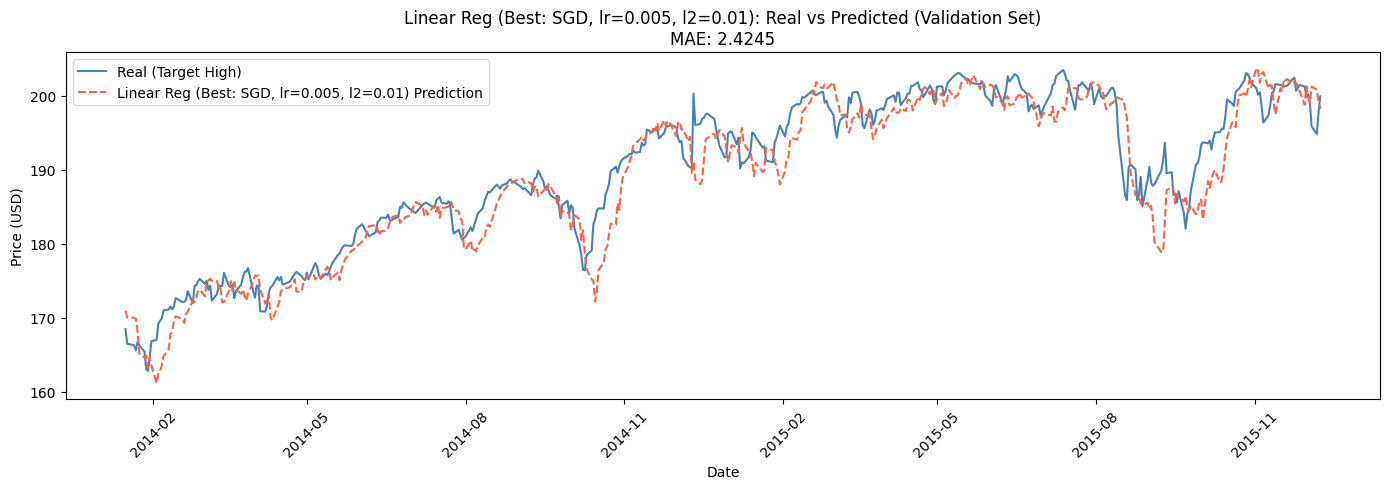

Plot saved as 'images/best_test_predictions_lr.png'


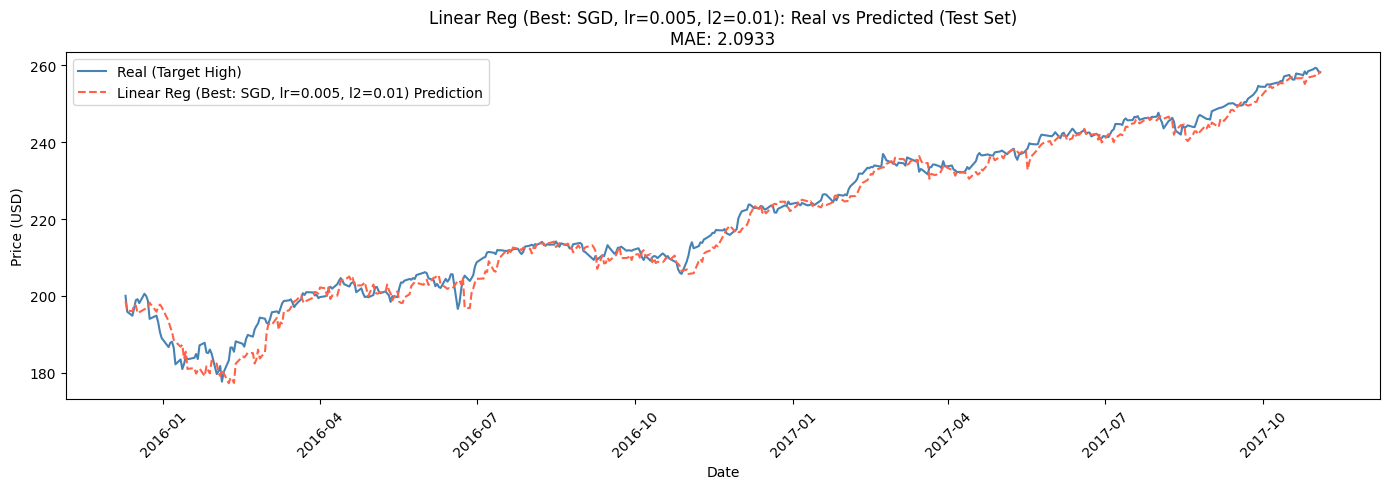

In [18]:
# 1. Define 5 hyperparameter configurations to test for Linear Regression
# optimizer: The optimization algorithm (SGD or Adam) and its Learning Rate (lr)
# l2: Regularization penalty to prevent overfitting (equivalent to Ridge Regression)
configurations_lr = [
    {'optimizer': optim.SGD(lr=0.01),   'l2': 0.0},    # Fast SGD, no regularization
    {'optimizer': optim.SGD(lr=0.001),  'l2': 0.1},    # Slow SGD, medium regularization
    {'optimizer': optim.SGD(lr=0.005),  'l2': 0.01},   # Moderate SGD, light regularization
    {'optimizer': optim.Adam(lr=0.01),  'l2': 0.0},    # Adam optimizer (adapts lr per feature)
    {'optimizer': optim.Adam(lr=0.001), 'l2': 0.1}     # Adam optimizer with regularization
]

# Variables to keep track of the best model
best_val_mae_lr = float('inf')
best_config_lr = None
best_test_mae_lr = None
best_records_val_lr = []
best_records_test_lr = []

print("Starting Hyperparameter Tuning for Online Linear Regression...\n")

# 2. Loop through each configuration
for run, config in enumerate(configurations_lr, 1):
    # Print the config name nicely since optimizer objects look messy when printed
    opt_name = config['optimizer'].__class__.__name__
    opt_lr = config['optimizer'].learning_rate
    print(f"--- Run {run}/5 | Opt: {opt_name}(lr={opt_lr}), L2: {config['l2']} ---")
    
    # We MUST recreate the pipeline from scratch for each run 
    # NOTICE: preprocessing.StandardScaler() is BACK. It is MANDATORY for Linear Models.
    river_model_lr = compose.Pipeline(
        OnlineSPYFeatures(),
        preprocessing.StandardScaler(), 
        linear_model.LinearRegression(
            optimizer=config['optimizer'],
            l2=config['l2']
        )
    )

    # Initialize fresh metrics and lists for this run
    metric_val_lr  = metrics.MAE()
    metric_test_lr = metrics.MAE()
    records_val_lr  = []
    records_test_lr = []

    # 3. Training Loop (Test-then-Train)
    for index, row in df.iterrows():
        x = row[['Open', 'High', 'Low', 'Close', 'Volume']].to_dict()
        y = row['Target_High']
        
        # PREDICTION
        y_pred = river_model_lr.predict_one(x)
        
        # UPDATE METRICS
        if index in X_val.index:
            metric_val_lr.update(y, y_pred)
            records_val_lr.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        elif index in X_test.index:
            metric_test_lr.update(y, y_pred)
            records_test_lr.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        # LEARNING
        river_model_lr.learn_one(x, y)

    # Current run results
    current_val_mae = metric_val_lr.get()
    current_test_mae = metric_test_lr.get()
    print(f"Result -> Val MAE: {current_val_mae:.4f} | Test MAE: {current_test_mae:.4f}\n")

    # 4. Check if this is the best model so far (based on Validation MAE)
    if current_val_mae < best_val_mae_lr:
        best_val_mae_lr = current_val_mae
        best_config_lr = config
        best_test_mae_lr = current_test_mae
        
        # Save the records of the best execution for later plotting
        best_records_val_lr = records_val_lr
        best_records_test_lr = records_test_lr

# 5. Final Results & Plotting
print("="*50)
print("BEST MODEL FOUND")
best_opt_name = best_config_lr['optimizer'].__class__.__name__
best_opt_lr = best_config_lr['optimizer'].learning_rate
print(f"Configuration : Optimizer: {best_opt_name}(lr={best_opt_lr}), L2: {best_config_lr['l2']}")
print(f"Validation MAE: {best_val_mae_lr:.4f}")
print(f"Test MAE      : {best_test_mae_lr:.4f}")
print("="*50)

# Plot using the records from the best configuration
plot_title = f"Linear Reg (Best: {best_opt_name}, lr={best_opt_lr}, l2={best_config_lr['l2']})"
mae_lr_val = plot_predictions_online(best_records_val_lr, 'Validation', plot_title, filename=IMG_DIR + 'best_validation_predictions_lr.png')
mae_lr_test = plot_predictions_online(best_records_test_lr, 'Test', plot_title, filename=IMG_DIR + 'best_test_predictions_lr.png')

#### Why does the Online Linear Regression produce a curved, adaptive line instead of a single straight line?

It might seem counterintuitive that a "Linear" Regression produces a highly dynamic, non-linear looking curve when plotted over time. This happens due to the fundamental difference between **Batch** and **Online** learning:

1. **Continuous Adaptation (`learn_one`):** In standard Batch linear regression, the model analyzes the entire dataset at once and computes a **single, static mathematical line** that best fits the whole history. However, in Online learning, the model updates its weights (coefficients) incrementally after every single prediction. 
2. **A "New" Line Every Day:** While the model is technically making predictions using a linear equation ($y = w_1x_1 + w_2x_2 + ... + b$), the weights ($w$) and the bias ($b$) are mutating daily. The plot you see is not one single line, but rather the connected sequence of individual predictions made by thousands of slightly different linear equations evolving over time.
3. **Tracking Local Trends:** Because optimization algorithms like SGD or Adam adjust the model's weights based on the most recent error, the model acts as a "trend follower". If the market shifts upward, the weights quickly adapt to predict higher prices for the next day, resulting in a curve that closely tracks the actual asset price.

### SRPRegressor

Streaming Random Patches (SRP) is an advanced ensemble algorithm specifically designed for online learning and data streams with concept drift. It operates as the dynamic, online equivalent of a Random Forest.

- Ensemble of Trees (n_models): The model trains multiple Hoeffding Trees simultaneously. Each tree produces an independent prediction, and the final output is their aggregated average. This approach significantly reduces variance and prevents overfitting compared to a single decision tree.

- Random Patches (subspace_size & lam): To ensure the trees remain diverse and do not memorize the same patterns, SRP applies 'Random Patches'. Each tree is trained on a random subset of features (subspaces) and a random subset of instances (simulated via a Poisson distribution, controlled by lam). This guarantees robustness, as no single dominant feature can dictate the entire model's behavior.

- Concept Drift Adaptation: Financial markets frequently change behavior. SRP natively handles this by continuously monitoring the performance of each individual tree using drift detectors (like ADWIN). If a tree's error rate spikes due to a sudden market shift, the algorithm replaces it with a fresh 'background tree'. This mechanism allows the model to adapt instantly to new financial trends without losing the valuable long-term patterns captured by stable trees.

Starting Hyperparameter Tuning for Online SRP Regressor...

--- Run 1/5 | Config: {'n_models': 10, 'subspace_size': 0.6, 'lam': 6.0} ---
Result -> Val MAE: 4.3540 | Test MAE: 5.5288

--- Run 2/5 | Config: {'n_models': 20, 'subspace_size': 0.6, 'lam': 6.0} ---
Result -> Val MAE: 4.1765 | Test MAE: 5.3256

--- Run 3/5 | Config: {'n_models': 20, 'subspace_size': 0.8, 'lam': 1.0} ---
Result -> Val MAE: 6.3786 | Test MAE: 7.4930

--- Run 4/5 | Config: {'n_models': 30, 'subspace_size': 0.8, 'lam': 6.0} ---
Result -> Val MAE: 4.1030 | Test MAE: 5.1289

--- Run 5/5 | Config: {'n_models': 30, 'subspace_size': 1.0, 'lam': 1.0} ---
Result -> Val MAE: 5.5554 | Test MAE: 6.5837

BEST MODEL FOUND
Configuration : {'n_models': 30, 'subspace_size': 0.8, 'lam': 6.0}
Validation MAE: 4.1030
Test MAE      : 5.1289
Plot saved as 'images/best_validation_predictions_srp.png'


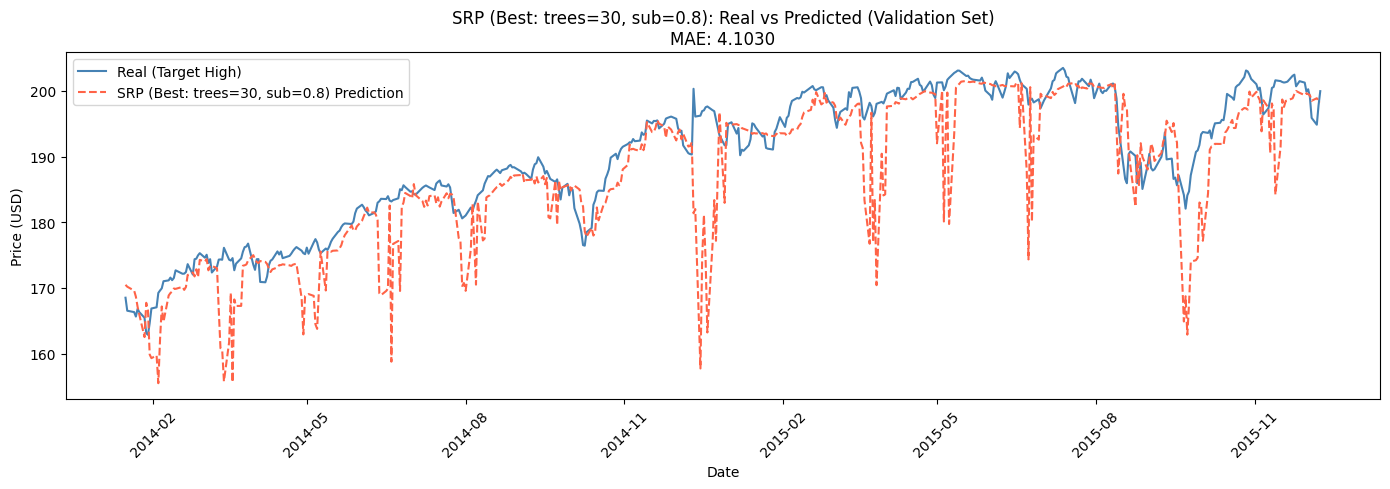

Plot saved as 'images/best_test_predictions_srp.png'


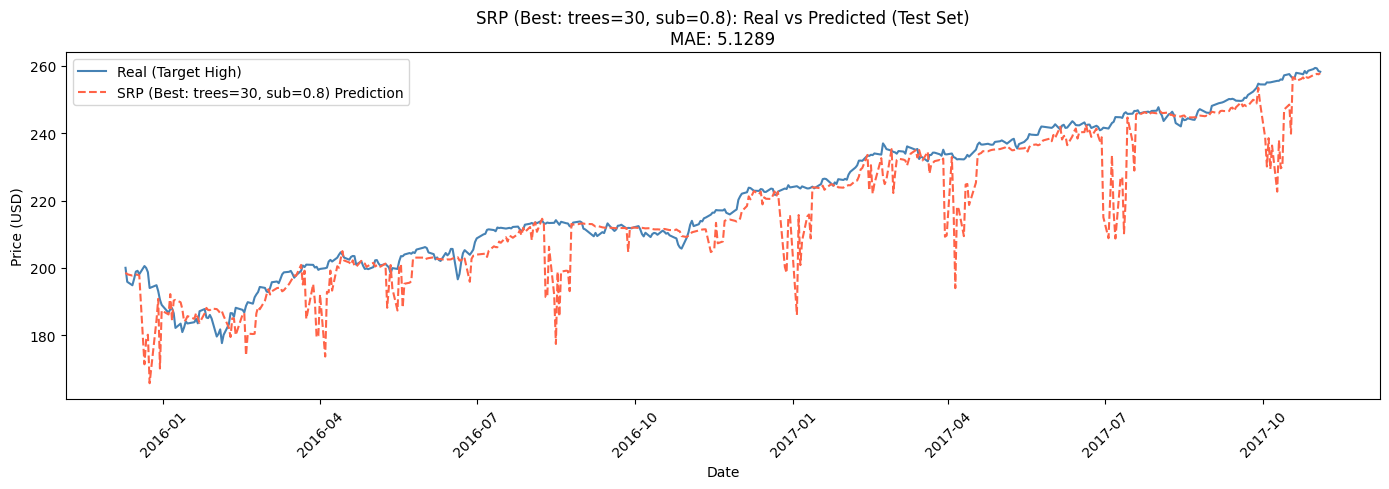

In [19]:
# 1. Define 5 hyperparameter configurations to test for SRP
# n_models: number of trees in the ensemble
# subspace_size: proportion of features to use per tree (Random Subspaces)
# lam: lambda for the Poisson distribution (Online Bagging / Resampling)
configurations_srp = [
    {'n_models': 10, 'subspace_size': 0.6, 'lam': 6.0},
    {'n_models': 20, 'subspace_size': 0.6, 'lam': 6.0},
    {'n_models': 20, 'subspace_size': 0.8, 'lam': 1.0}, # lam=1.0 is standard online bagging
    {'n_models': 30, 'subspace_size': 0.8, 'lam': 6.0}, # lam=6.0 is leveraging bagging (more weight to some instances)
    {'n_models': 30, 'subspace_size': 1.0, 'lam': 1.0}  # 1.0 means all features (like standard bagging)
]

# Variables to keep track of the best model
best_val_mae_srp = float('inf')
best_config_srp = None
best_test_mae_srp = None
best_records_val_srp = []
best_records_test_srp = []

print("Starting Hyperparameter Tuning for Online SRP Regressor...\n")

# 2. Loop through each configuration
for run, config in enumerate(configurations_srp, 1):
    print(f"--- Run {run}/5 | Config: {config} ---")
    
    # We MUST recreate the pipeline from scratch for each run 
    # to prevent the ensemble from carrying over memory from the previous run.
    # We define a base tree, and detectors for warning and drift.
    river_model_srp = compose.Pipeline(
        OnlineSPYFeatures(),
        preprocessing.StandardScaler(), 
        ensemble.SRPRegressor(
            model=tree.HoeffdingTreeRegressor(grace_period=50),
            n_models=config['n_models'],
            subspace_size=config['subspace_size'],
            lam=config['lam'],
            drift_detector=drift.ADWIN(),
            warning_detector=drift.ADWIN(),
            seed=SEED
        )
    )

    # Initialize fresh metrics and lists for this run
    metric_val_srp  = metrics.MAE()
    metric_test_srp = metrics.MAE()
    records_val_srp  = []
    records_test_srp = []

    # 3. Training Loop (Test-then-Train)
    for index, row in df.iterrows():
        x = row[['Open', 'High', 'Low', 'Close', 'Volume']].to_dict()
        y = row['Target_High']
        
        # PREDICTION
        y_pred = river_model_srp.predict_one(x)
        
        # UPDATE METRICS
        if index in X_val.index:
            metric_val_srp.update(y, y_pred)
            records_val_srp.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        elif index in X_test.index:
            metric_test_srp.update(y, y_pred)
            records_test_srp.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
            
        # LEARNING
        river_model_srp.learn_one(x, y)

    # Current run results
    current_val_mae = metric_val_srp.get()
    current_test_mae = metric_test_srp.get()
    print(f"Result -> Val MAE: {current_val_mae:.4f} | Test MAE: {current_test_mae:.4f}\n")

    # 4. Check if this is the best model so far (based on Validation MAE)
    if current_val_mae < best_val_mae_srp:
        best_val_mae_srp = current_val_mae
        best_config_srp = config
        best_test_mae_srp = current_test_mae
        
        # Save the records of the best execution for later plotting
        best_records_val_srp = records_val_srp
        best_records_test_srp = records_test_srp

# 5. Final Results & Plotting
print("="*50)
print("BEST MODEL FOUND")
print(f"Configuration : {best_config_srp}")
print(f"Validation MAE: {best_val_mae_srp:.4f}")
print(f"Test MAE      : {best_test_mae_srp:.4f}")
print("="*50)

# Plot using the records from the best configuration
plot_title = f"SRP (Best: trees={best_config_srp['n_models']}, sub={best_config_srp['subspace_size']})"
mae_srp_val = plot_predictions_online(best_records_val_srp, 'Validation', plot_title, filename=IMG_DIR + 'best_validation_predictions_srp.png')
mae_srp_test = plot_predictions_online(best_records_test_srp, 'Test', plot_title, filename=IMG_DIR + 'best_test_predictions_srp.png')

### Concept Drift Detection (online)

Following the same methodology applied to our batch models, we will now monitor the presence of concept drift in our online models. To do this, we use the `analyze_and_plot_drift_online` function, which applies the ADWIN and Page-Hinkley detectors to the sequential error stream of our online predictions. This allows us to observe when major market shifts occurred and verify if the online models adapted to the new data.


--- Analyzing Concept Drift for Hoefding (Validation) ---
ADWIN detected 2 drift points.
Page-Hinkley detected 5 drift points.
Plot saved as 'images/validation_drift_hoef.png'


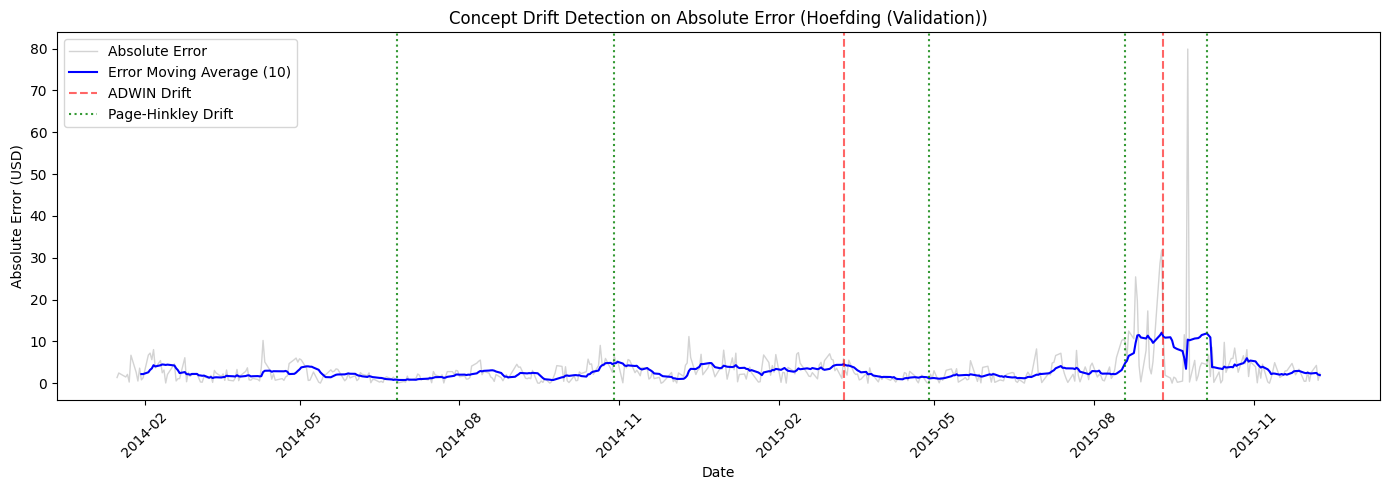


--- Analyzing Concept Drift for Hoefding (Test) ---
ADWIN detected 1 drift points.
Page-Hinkley detected 3 drift points.
Plot saved as 'images/test_drift_hoef.png'


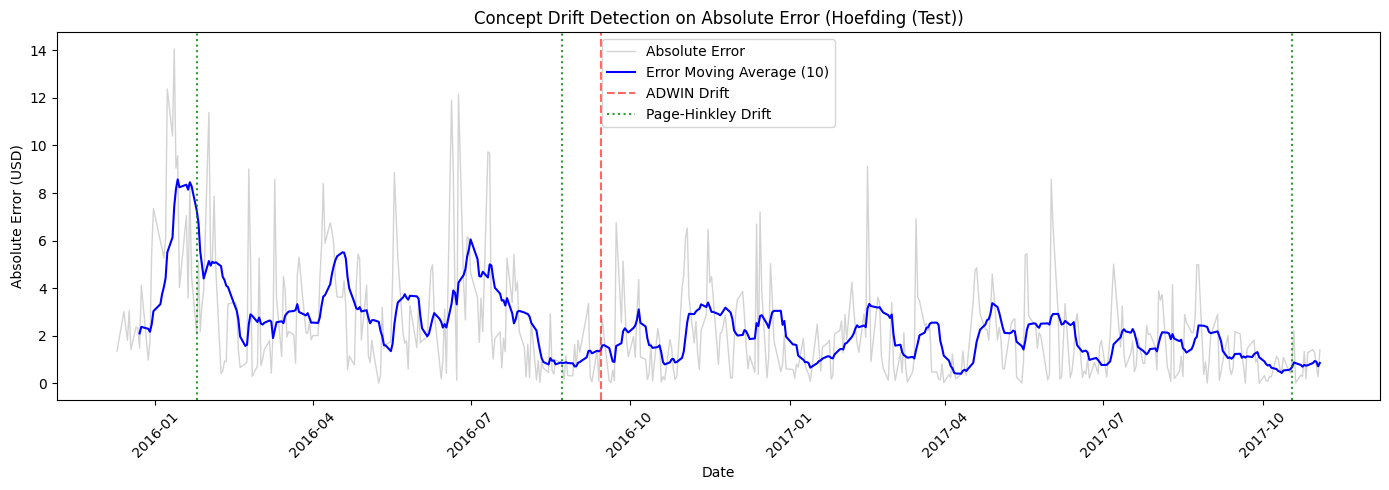

In [20]:
adwin_val_hoef, ph_val_hoef = analyze_and_plot_drift_online(best_records_val_hoef, "Hoefding (Validation)", filename=IMG_DIR + 'validation_drift_hoef.png')
adwin_test_hoef, ph_test_hoef = analyze_and_plot_drift_online(best_records_test_hoef, "Hoefding (Test)", filename=IMG_DIR + 'test_drift_hoef.png')


--- Analyzing Concept Drift for KNN (Validation) ---
ADWIN detected 1 drift points.
Page-Hinkley detected 4 drift points.
Plot saved as 'images/validation_drift_knn.png'


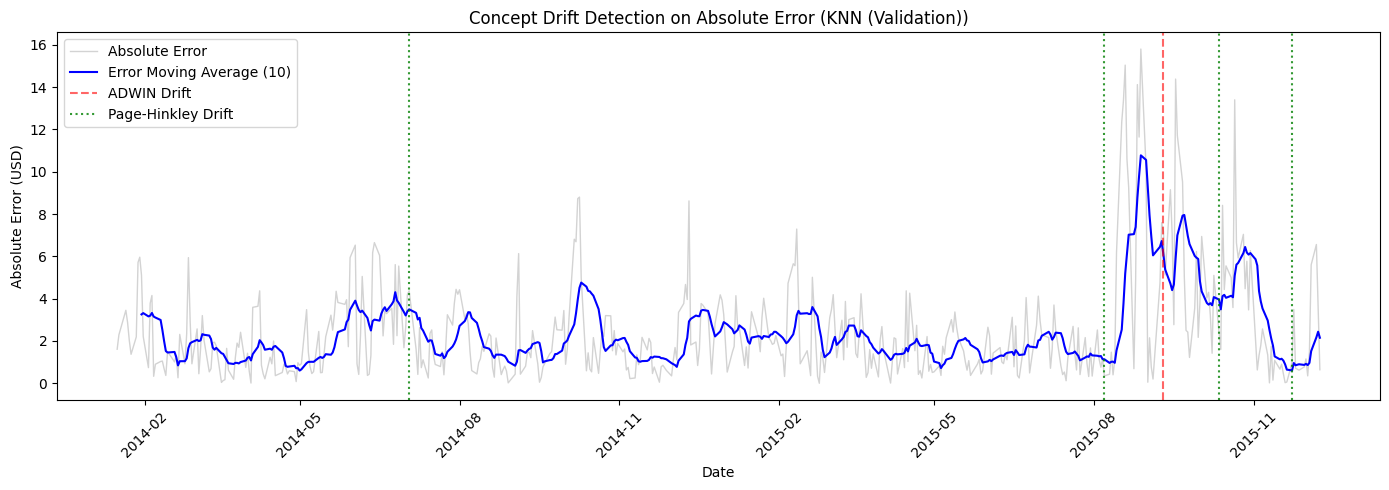


--- Analyzing Concept Drift for KNN (Test) ---
ADWIN detected 2 drift points.
Page-Hinkley detected 7 drift points.
Plot saved as 'images/test_drift_knn.png'


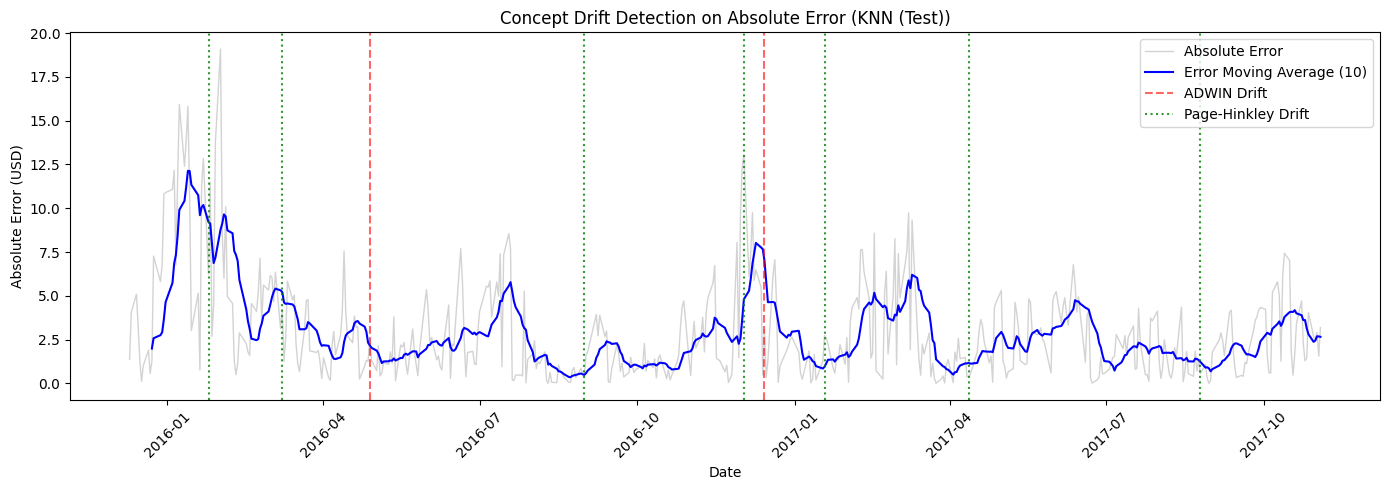

In [21]:
adwin_val_knn, ph_val_knn = analyze_and_plot_drift_online(best_records_val_knn, "KNN (Validation)", filename=IMG_DIR + 'validation_drift_knn.png')
adwin_test_knn, ph_test_knn = analyze_and_plot_drift_online(best_records_test_knn, "KNN (Test)", filename=IMG_DIR + 'test_drift_knn.png')


--- Analyzing Concept Drift for Logistic Regression (Validation) ---
ADWIN detected 2 drift points.
Page-Hinkley detected 6 drift points.
Plot saved as 'images/validation_drift_lr.png'


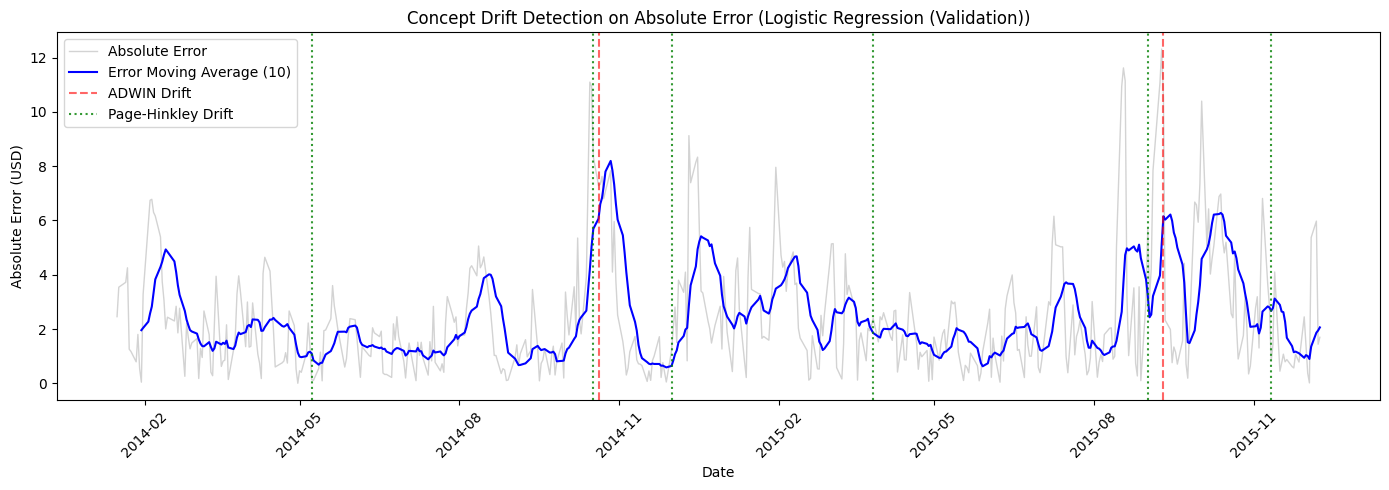


--- Analyzing Concept Drift for Logistic Regression (Test) ---
ADWIN detected 2 drift points.
Page-Hinkley detected 5 drift points.
Plot saved as 'images/test_drift_lr.png'


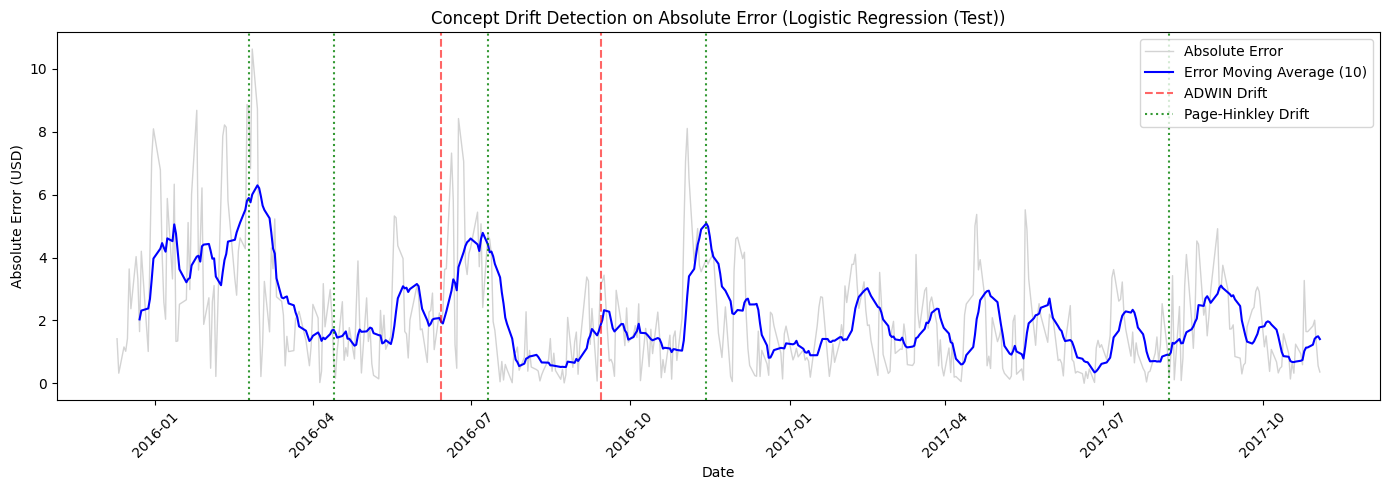

In [22]:
adwin_val_lr, ph_val_lr = analyze_and_plot_drift_online(best_records_val_lr, "Logistic Regression (Validation)", filename=IMG_DIR + 'validation_drift_lr.png')
adwin_test_lr, ph_test_lr = analyze_and_plot_drift_online(best_records_test_lr, "Logistic Regression (Test)", filename=IMG_DIR + 'test_drift_lr.png')


--- Analyzing Concept Drift for SRP (Validation) ---
ADWIN detected 1 drift points.
Page-Hinkley detected 12 drift points.
Plot saved as 'images/validation_drift_srp.png'


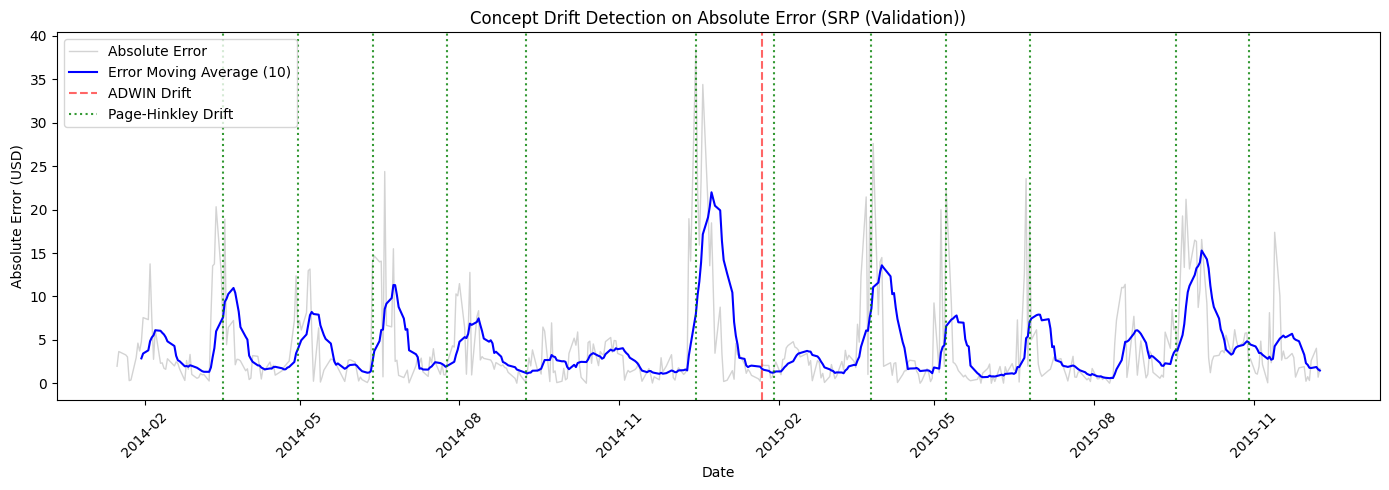


--- Analyzing Concept Drift for SRP (Test) ---
ADWIN detected 0 drift points.
Page-Hinkley detected 14 drift points.
Plot saved as 'images/test_drift_srp.png'


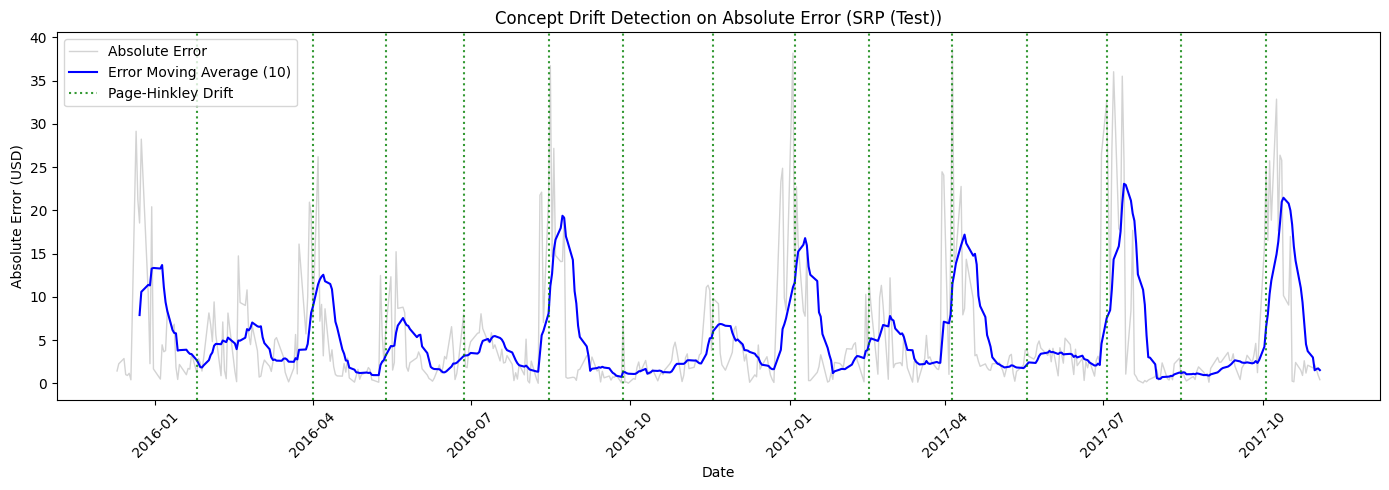

In [23]:
adwin_val_srp, ph_val_srp = analyze_and_plot_drift_online(best_records_val_srp, "SRP (Validation)", filename=IMG_DIR + 'validation_drift_srp.png')
adwin_test_srp, ph_test_srp = analyze_and_plot_drift_online(best_records_test_srp, "SRP (Test)", filename=IMG_DIR + 'test_drift_srp.png')